# AutoEncoder for CSC

###  Import and function definition

In [1]:
import pandas as pd
import numpy as np
import math, time, copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using:", device)

You are using: cuda


In [2]:
def Show2Dimg(img, title='CSC occupancy'):
    img_temp = copy.deepcopy(img)
    cmap = plt.cm.jet
    cmap.set_under(color='white')
    max_=np.max(img_temp)
    img_temp[img_temp==0] = np.nan
    plt.imshow(img_temp, cmap=cmap, vmin=0.0000000001, vmax=max_)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    del img_temp

def PLots_in_training(X, Xreco):
    print(' >> original image:')
    img = X[0][0].cpu().numpy()
    Show2Dimg(img)
    print(' >> AE-reco image:')
    img_reco = Xreco[0][0].detach().cpu().numpy()
    Show2Dimg(img_reco)
    print(' >> loss map:')
    img_loss = F.mse_loss(Xreco[0], X[0], reduction='none')[0].detach().cpu().numpy()
    Show2Dimg(img_loss)

### Loading Data from previous strep

In [3]:
me = "hRHGlobalm3"
data = np.load(me+'_files.npz')
selected_chamber = data["imgs"]

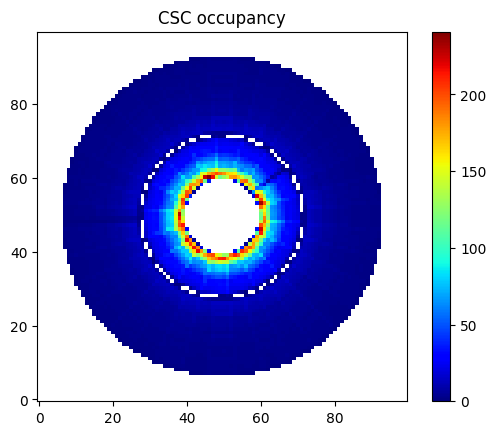

In [4]:
mean_matrix = np.mean(selected_chamber, axis=0)
dim = len(selected_chamber)
Show2Dimg(mean_matrix)
mean_matrix[mean_matrix == 0] = np.nan

In [5]:
tensor_list = [(torch.tensor(m, dtype=torch.float32)).unsqueeze(0) for m in selected_chamber]
print(tensor_list[0].size())
training_dim = int(dim*0.85)
training_tensor = tensor_list[:training_dim]
validation_tensor = tensor_list[training_dim:]
print(f"Data ({len(selected_chamber)}) = Training sample ({len(training_tensor)}) + Validation sample ({len(validation_tensor)})")

torch.Size([1, 100, 100])
Data (4321) = Training sample (3672) + Validation sample (649)


In [6]:
#for k in range(len(validation_tensor)):
#    for i in range(50, 100):
#        for j in range(50, 100):
#            if (i<1.3*j-15 and i>0.7*j+15):
#                validation_tensor[k][0][i][j]=0

In [7]:
training_dataset = TensorDataset(*training_tensor)
validation_dataset = TensorDataset(*validation_tensor)

training_loader = DataLoader(dataset=training_tensor, 
                             batch_size=64, 
                             num_workers=10, 
                             shuffle=True)

validation_loader = DataLoader(dataset=validation_tensor, 
                               batch_size=32,
                               num_workers=10, 
                               shuffle=False)

### Define ResNet Model

In [8]:
class ResBlock(nn.Module):
    '''
    For encoding, define the nominal resnet block
    '''
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

class ResBlockTranspose(nn.Module):
    '''
    For decoding, define the transposed resnet block, aka "de-convolution"
    '''
    def __init__(self, in_channels, out_channels, out_shape=None):
        super(ResBlockTranspose, self).__init__()
        self.upsample = in_channels//out_channels  
        self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample)
        self.out_shape = out_shape

    def forward(self, x):
        residual = x
        
        if self.out_shape is None:
            out = self.convT1(x)
        else:
            out = self.convT1(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
        out = self.relu(out)
        out = self.convT2(out)

        if self.upsample > 1:
            if self.out_shape is None:
                residual = self.shortcutT(x)
            else:
                residual = self.shortcutT(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
            
        out += residual
        out = self.relu(out)

        return out

In [9]:
class ResNetAE(nn.Module):
    '''
    Define the full ResNet autoencoder model
    '''
    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNetAE, self).__init__()

        self.fmaps = fmaps
        self.nblocks = nblocks
        self.in_channels = in_channels
        
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=3, stride=1, padding=1), nn.ReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        self.elayer4 = self.block_layers(1, [fmaps[1],fmaps[2]], 'enc')
        self.elayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[-1], self.fmaps[-1]*13*13) # 5x5
        self.dlayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'dec', out_shape=None)
        self.dlayer4 = self.block_layers(1, [fmaps[2],fmaps[1]], 'dec', out_shape=(25,25))
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(50,50))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=3, stride=1, padding=(1,1))
        self.dconv0_relu = nn.ReLU(inplace=True)
        
        self.debug = False
        #self.debug = True

    def block_layers(self, nblocks, fmaps, state, out_shape=None):
        '''
        Convenience function: append several resnet blocks in sequence
        '''
        layers = []
        for _ in range(nblocks):
            if state == 'enc':
                layers.append(ResBlock(fmaps[0], fmaps[1]))
            else:
                layers.append(ResBlockTranspose(fmaps[0], fmaps[1], out_shape)) 
        return nn.Sequential(*layers)


    def forward(self, x):
        
        # Encoding
        if self.debug: print(x.size())
        if self.debug: print("Encode")
        x = self.econv0(x)
        if self.debug: print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        if self.debug: print(x.size())

        x = self.elayer1(x)
        if self.debug: print(x.size())
        x = self.elayer2(x)
        if self.debug: print(x.size())
        x = self.elayer3(x)
        if self.debug: print(x.size()) #32x9x18
        x = self.elayer4(x)
        if self.debug: print(x.size())
        x = self.elayer5(x)
        if self.debug: print(x.size())
        
        # Bottleneck comes from GlobalMaxPool
        if self.debug: print("Maxpool-FC")
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        if self.debug: print(x.size())
        x = x.view(x.size()[0], -1)
        if self.debug: print(x.size())
        
        # Expand bottleneck
        # Dimensions follow encoding steps in reverse, as much as possible
        x = self.fc(x) # expand   
        if self.debug: print(x.size())
        #x = x.view(-1, self.fmaps[1], 4, 9) 
        #x = x.view(-1, self.fmaps[1], 9, 18) 
        x = x.view(-1, self.fmaps[-1], 13, 13) 
        if self.debug: print(x.size())        
        
        # Decoding
        if self.debug: print("Decode")
        x = self.dlayer5(x)
        if self.debug: print(x.size())
        x = self.dlayer4(x)
        if self.debug: print(x.size())
        x = self.dlayer3(x)
        if self.debug: print(x.size())
        x = self.dlayer2(x)
        if self.debug: print(x.size())
        x = self.dlayer1(x)
        if self.debug: print(x.size())
        
        x = F.interpolate(x, scale_factor=2)
        if self.debug: print(x.size())
        x = self.dconv0(x, output_size=(x.size()[0], self.in_channels, 100, 100))
        if self.debug: print(x.size())
        x = self.dconv0_relu(x)
            
        return x
        #return x, mu, logvar

### Training Loop

In [12]:
ae = ResNetAE(1, 3, [16, 32, 64]).to(device)
optimizer = optim.Adam(ae.parameters(), lr=5.e-4)
train_loss, val_loss =[], []
epochs = 10
for e in range(epochs):
    epoch = e+1
    print(f'***** Training Epoch {epoch} *****')
    # Run training
    ae.train()
    now = time.time()
    tloss=[]
    for i, figure in enumerate(training_loader):
        X = figure.to(device)
        #X = X
        optimizer.zero_grad()
        Xreco = ae(X)
        
        #if i==1:
        #    PLots_in_training(X, Xreco)
        #print(X)
        #loss = F.l1_loss(Xreco, X)
        #loss = F.mse_loss(Xreco, X) smooth_l1_loss
        loss = F.l1_loss(Xreco, X)
        tloss.append(loss.item())
        loss.backward()
        optimizer.step()
        if i%4 ==0:
            print(f'>> [{i}/{len(training_loader)}] Train loss:{loss.item()}')
    train_loss.append(np.mean(tloss))
    now = time.time() - now
    s = '>> Training time: %.2f min in %d steps'%( now/60, len(training_loader))
    print(s)

***** Training Epoch 1 *****
>> [0/58] Train loss:8.673444747924805
>> [4/58] Train loss:8.53788948059082
>> [8/58] Train loss:8.713618278503418
>> [12/58] Train loss:8.821856498718262
>> [16/58] Train loss:8.487004280090332
>> [20/58] Train loss:8.379109382629395
>> [24/58] Train loss:8.51489543914795
>> [28/58] Train loss:7.868723392486572
>> [32/58] Train loss:6.737644195556641
>> [36/58] Train loss:6.5190887451171875
>> [40/58] Train loss:5.720807075500488
>> [44/58] Train loss:5.056661605834961
>> [48/58] Train loss:4.756926536560059
>> [52/58] Train loss:4.459192752838135
>> [56/58] Train loss:4.231839179992676
>> Training time: 0.10 min in 58 steps
***** Training Epoch 2 *****
>> [0/58] Train loss:4.17584228515625
>> [4/58] Train loss:3.945648431777954
>> [8/58] Train loss:3.9442992210388184
>> [12/58] Train loss:3.7002382278442383
>> [16/58] Train loss:3.6748948097229004
>> [20/58] Train loss:3.623359203338623
>> [24/58] Train loss:3.5258076190948486
>> [28/58] Train loss:3.448

### Validation dataset

***** batch 0 *****
 >> Example 0
 >> Original image:


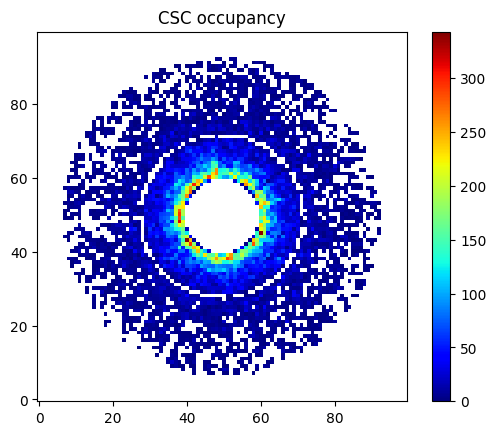

 >> AE-reco image:


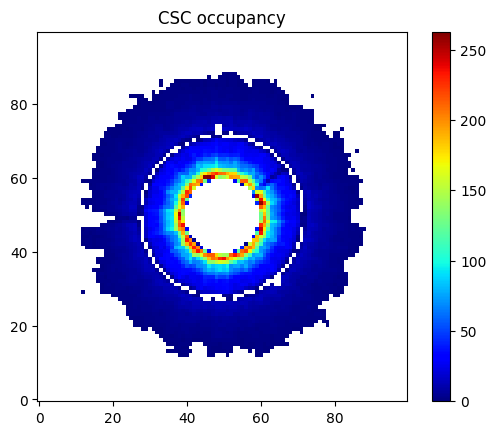

 >> Normalized loss map:


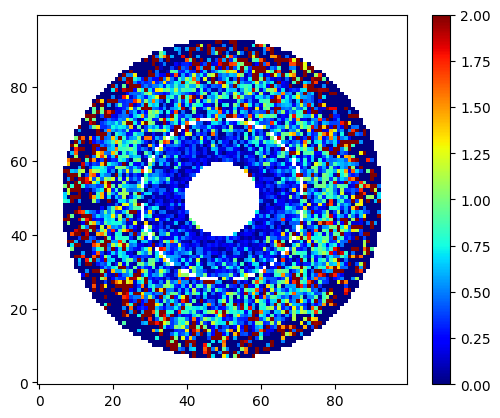

 >> Example 1
 >> Original image:


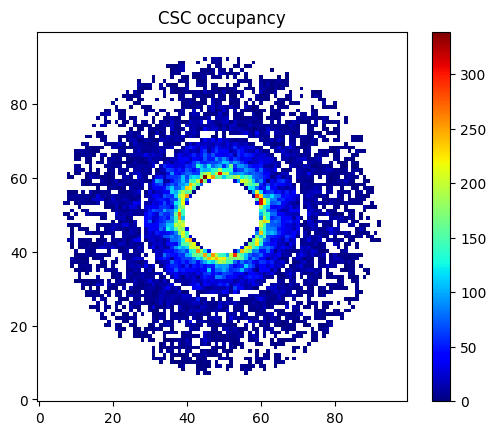

 >> AE-reco image:


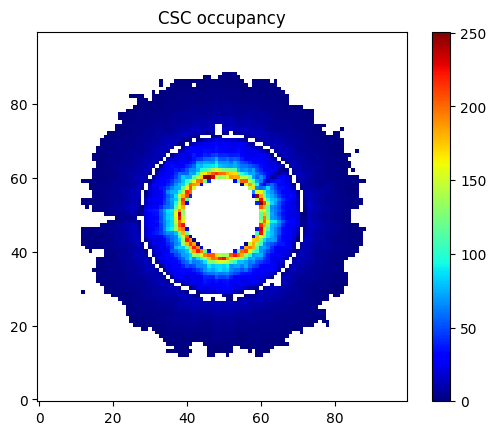

 >> Normalized loss map:


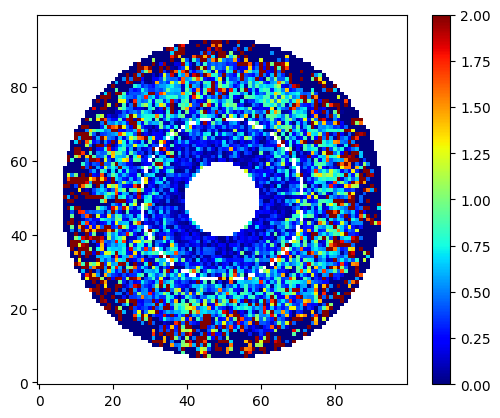

 >> Example 2
 >> Original image:


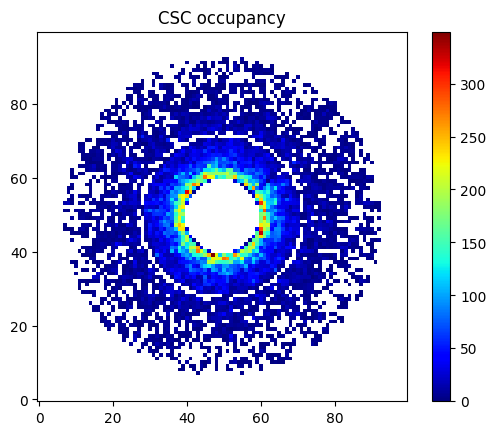

 >> AE-reco image:


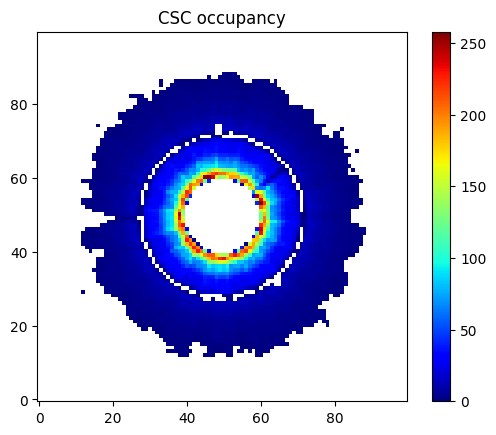

 >> Normalized loss map:


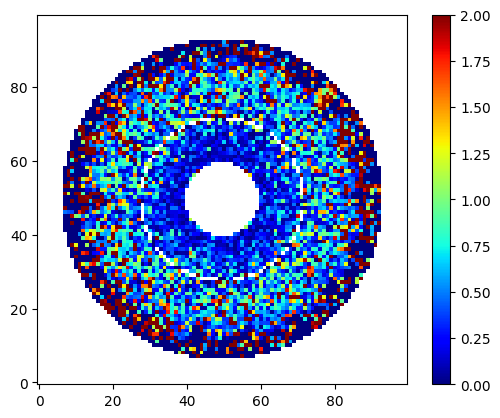

 >> Example 3
 >> Original image:


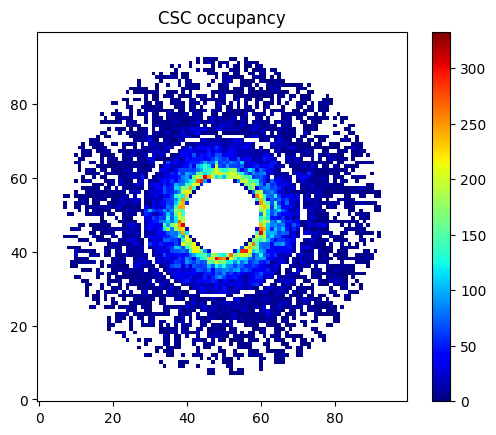

 >> AE-reco image:


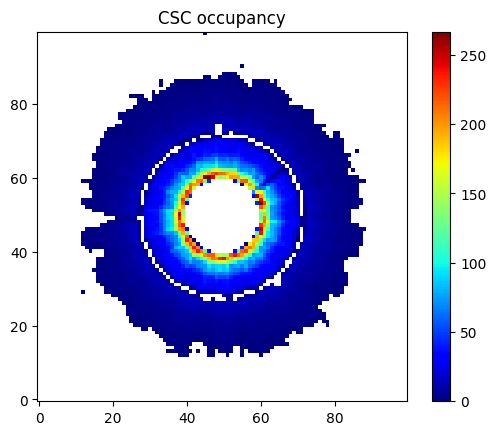

 >> Normalized loss map:


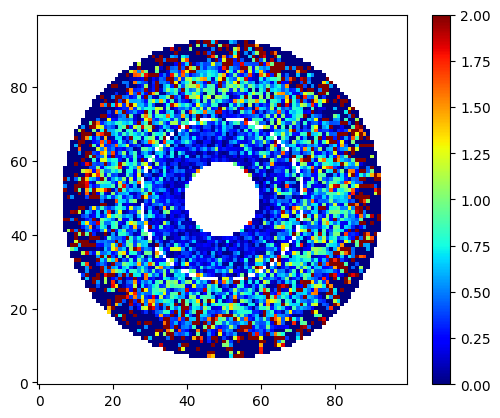

***** batch 1 *****
 >> Example 0
 >> Original image:


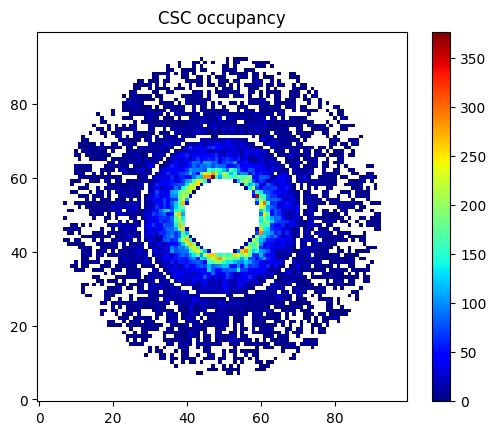

 >> AE-reco image:


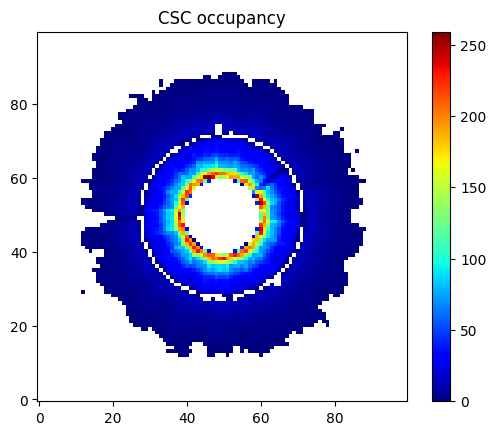

 >> Normalized loss map:


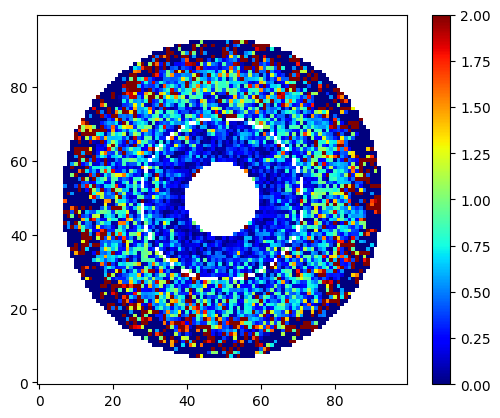

 >> Example 1
 >> Original image:


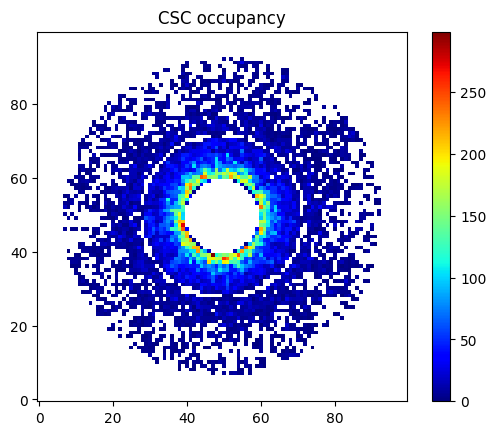

 >> AE-reco image:


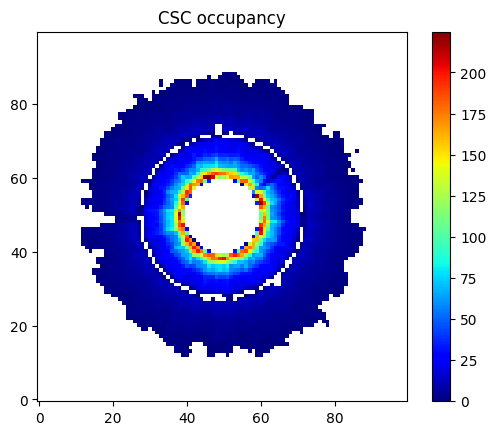

 >> Normalized loss map:


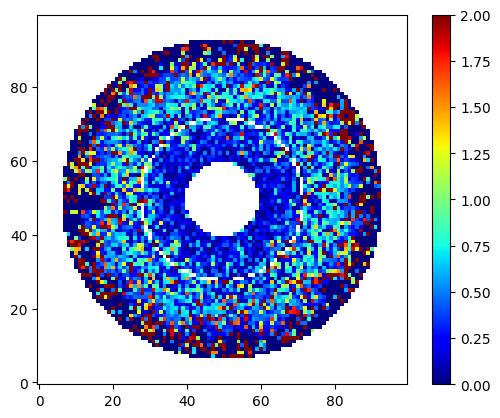

 >> Example 2
 >> Original image:


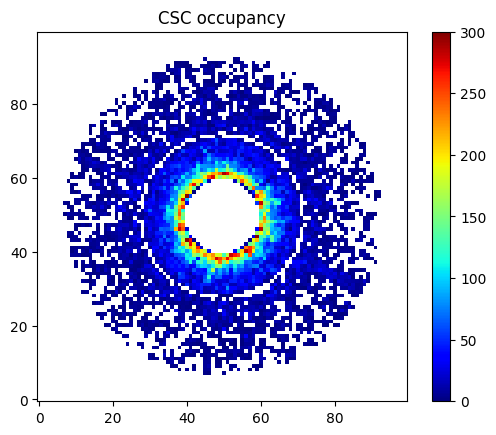

 >> AE-reco image:


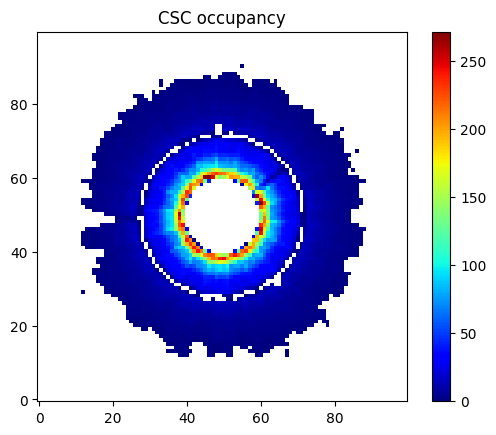

 >> Normalized loss map:


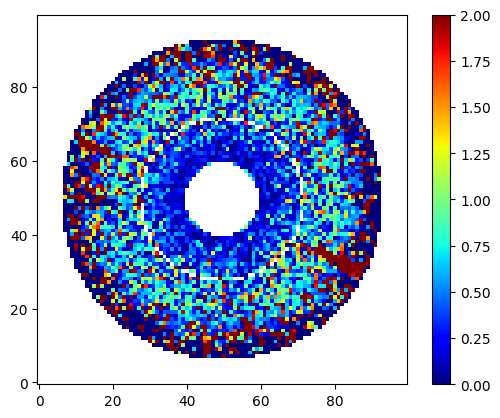

 >> Example 3
 >> Original image:


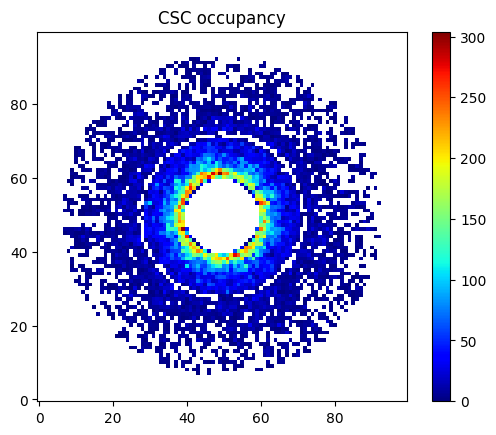

 >> AE-reco image:


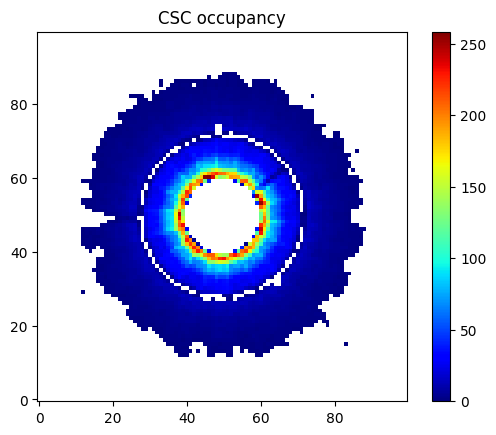

 >> Normalized loss map:


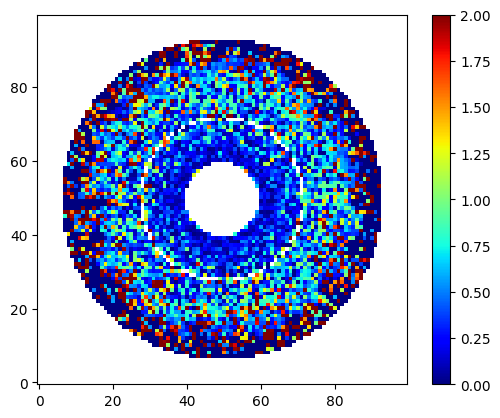

***** batch 2 *****
 >> Example 0
 >> Original image:


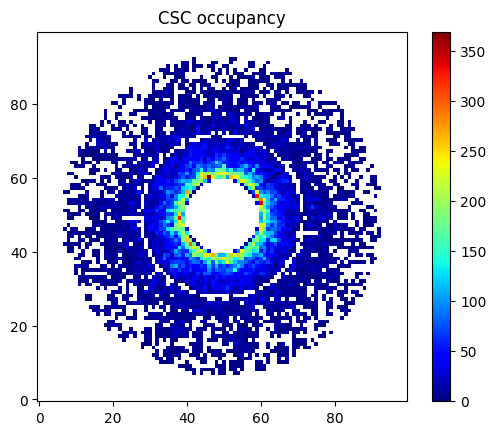

 >> AE-reco image:


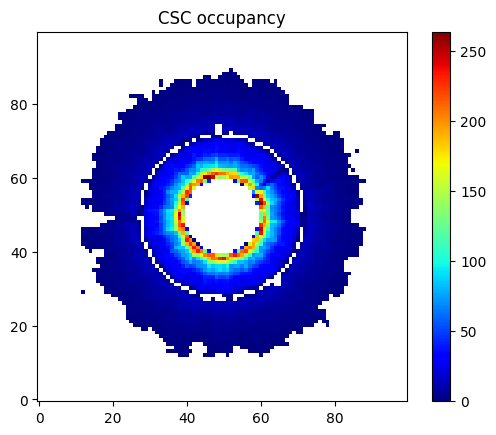

 >> Normalized loss map:


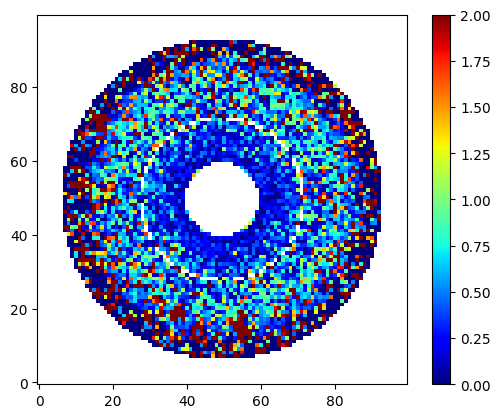

 >> Example 1
 >> Original image:


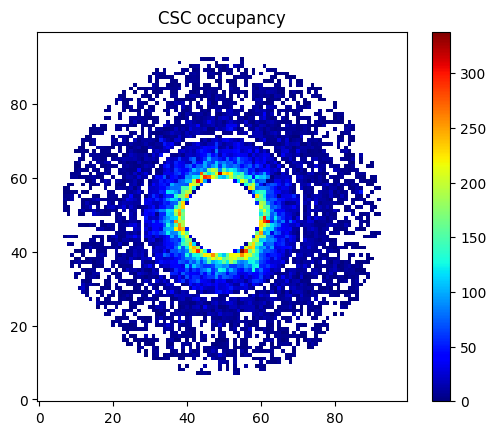

 >> AE-reco image:


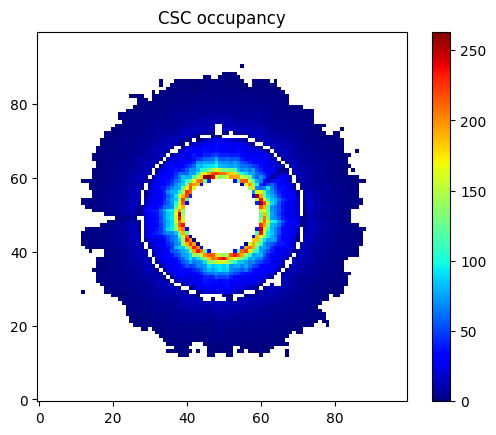

 >> Normalized loss map:


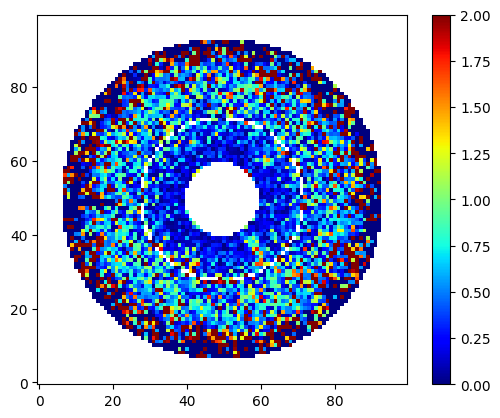

 >> Example 2
 >> Original image:


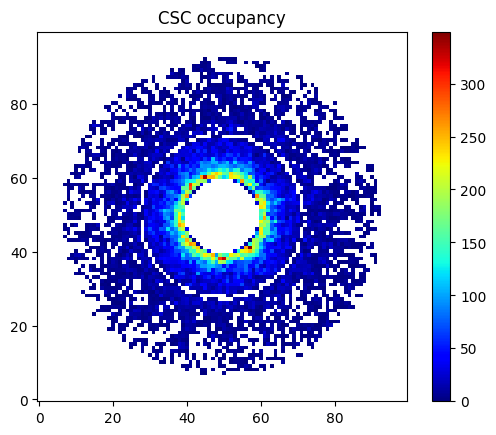

 >> AE-reco image:


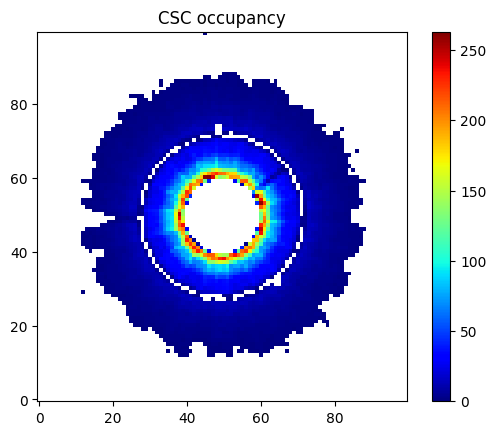

 >> Normalized loss map:


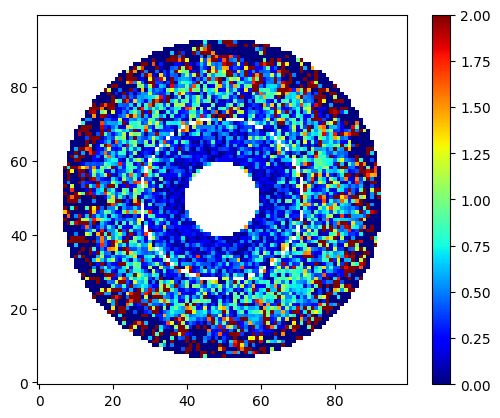

 >> Example 3
 >> Original image:


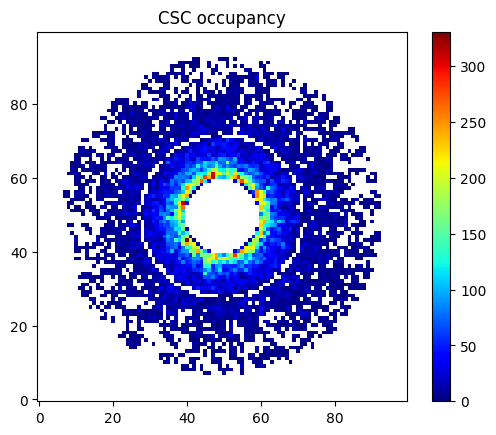

 >> AE-reco image:


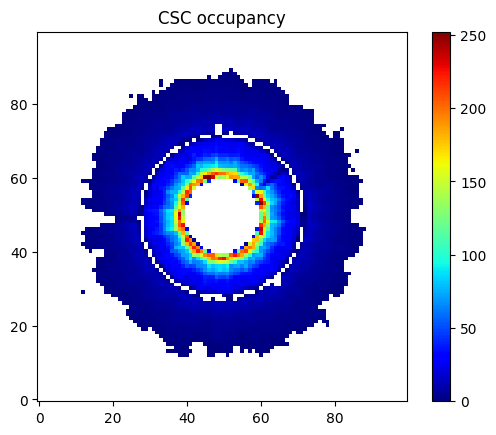

 >> Normalized loss map:


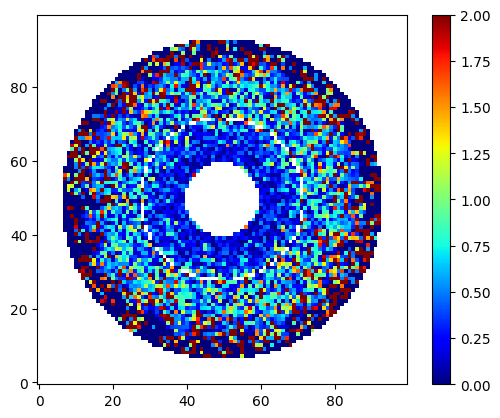

***** batch 3 *****
 >> Example 0
 >> Original image:


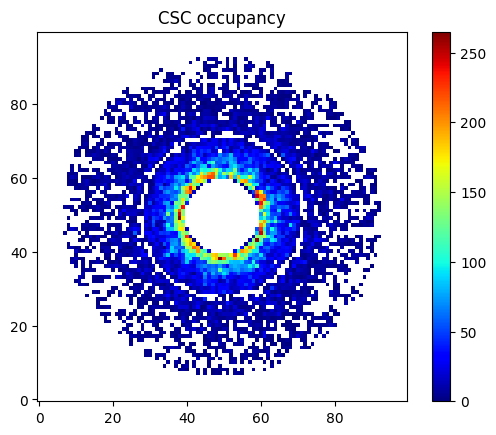

 >> AE-reco image:


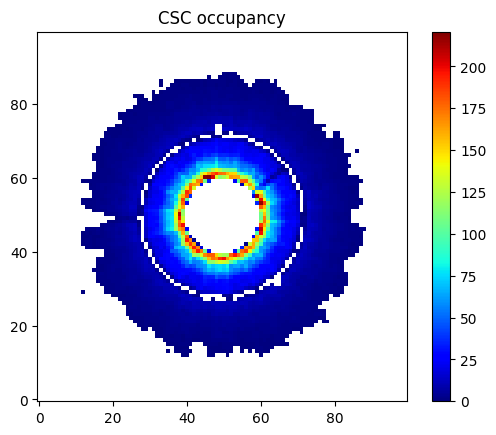

 >> Normalized loss map:


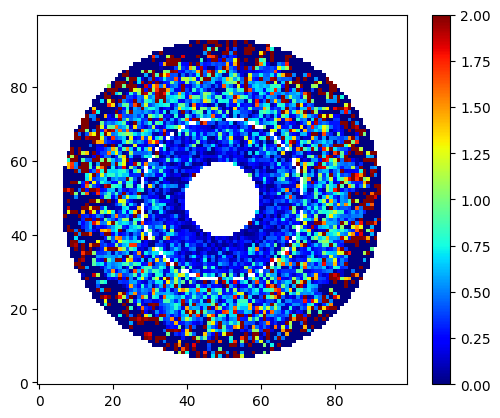

 >> Example 1
 >> Original image:


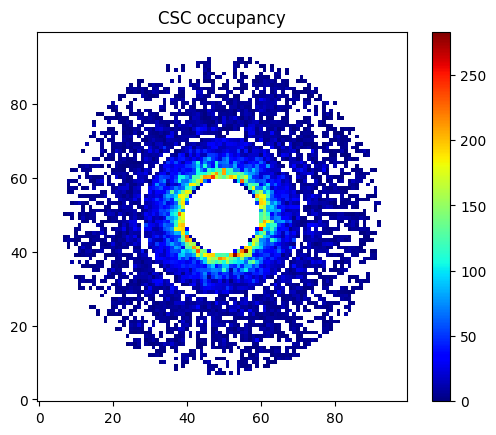

 >> AE-reco image:


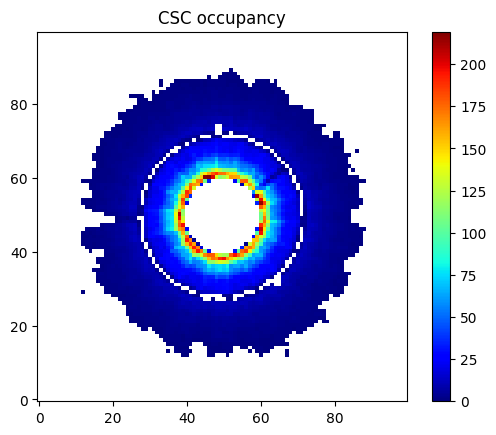

 >> Normalized loss map:


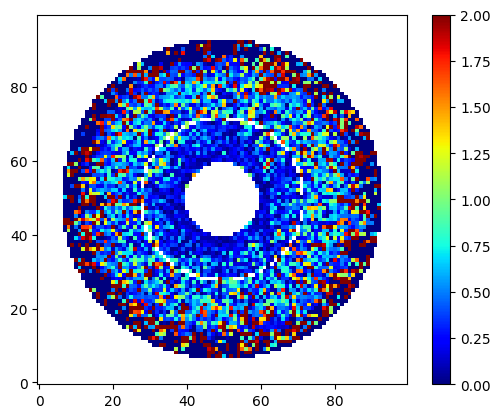

 >> Example 2
 >> Original image:


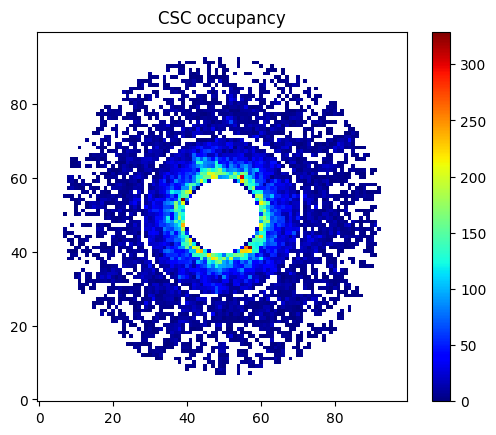

 >> AE-reco image:


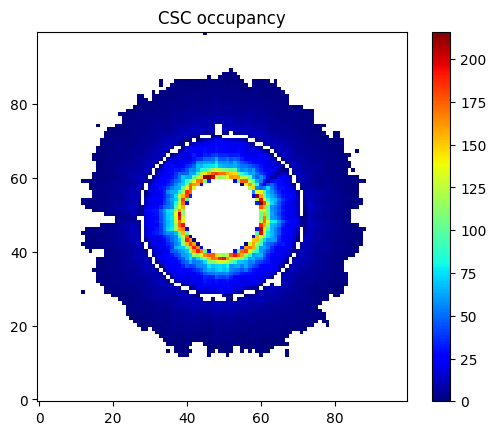

 >> Normalized loss map:


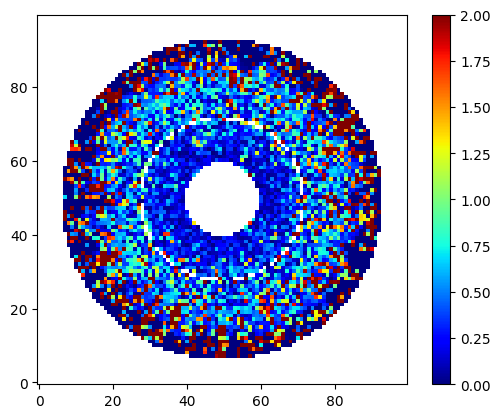

 >> Example 3
 >> Original image:


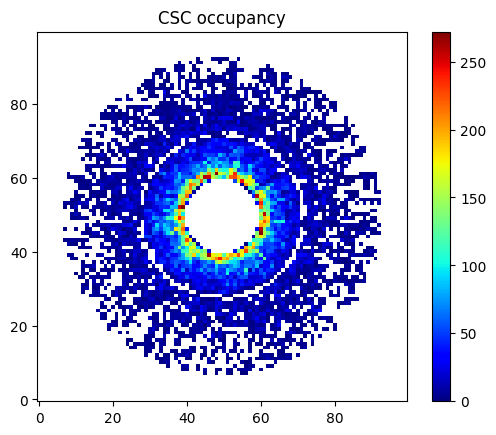

 >> AE-reco image:


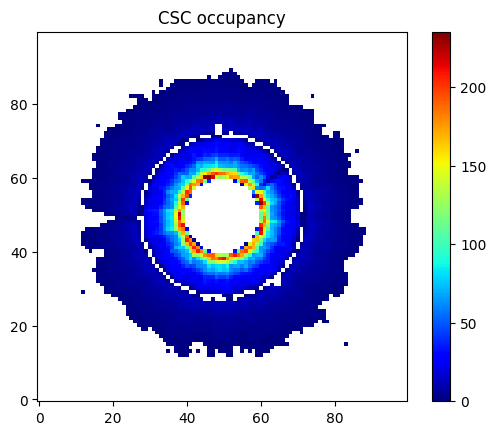

 >> Normalized loss map:


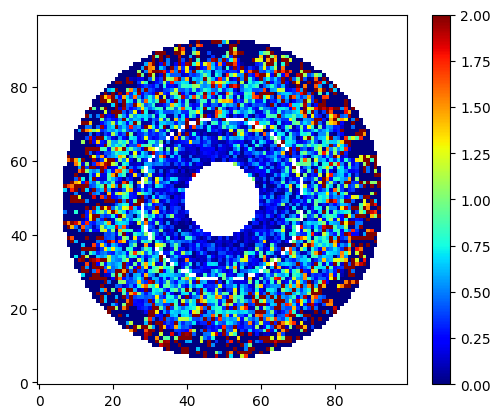

***** batch 4 *****
 >> Example 0
 >> Original image:


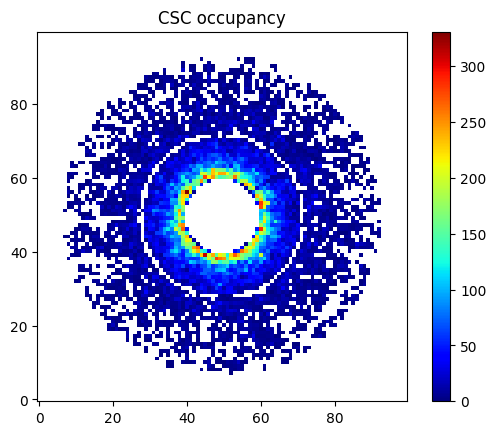

 >> AE-reco image:


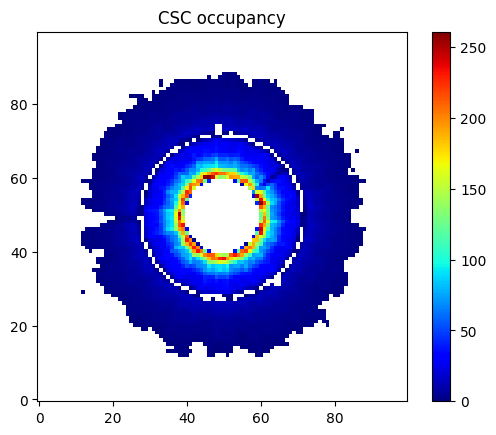

 >> Normalized loss map:


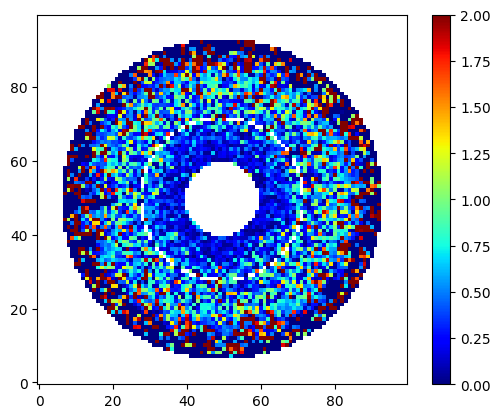

 >> Example 1
 >> Original image:


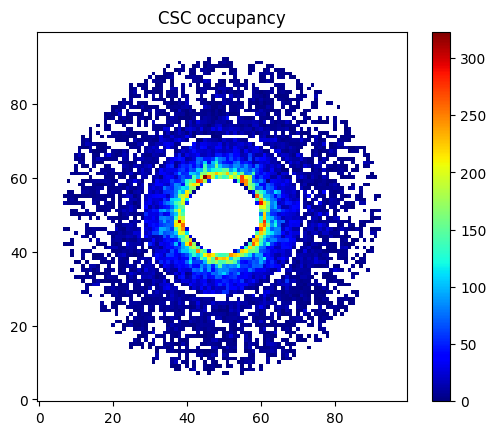

 >> AE-reco image:


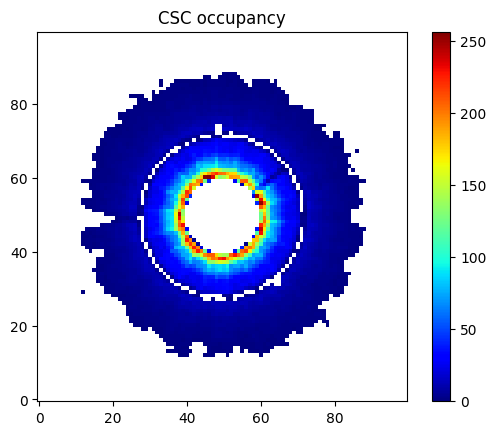

 >> Normalized loss map:


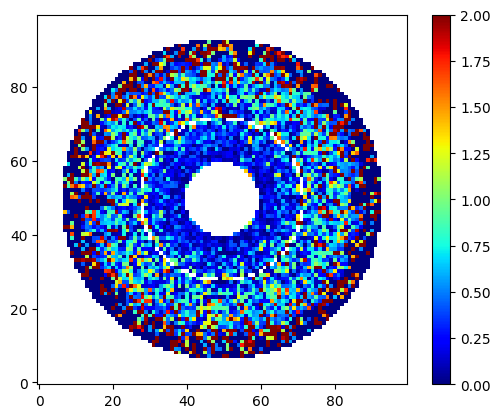

 >> Example 2
 >> Original image:


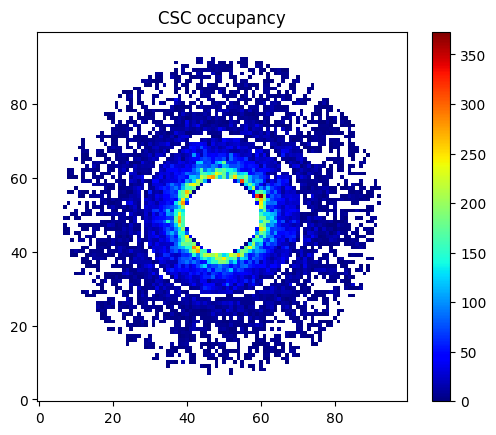

 >> AE-reco image:


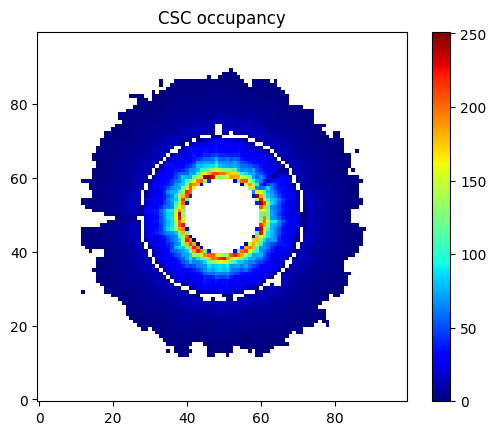

 >> Normalized loss map:


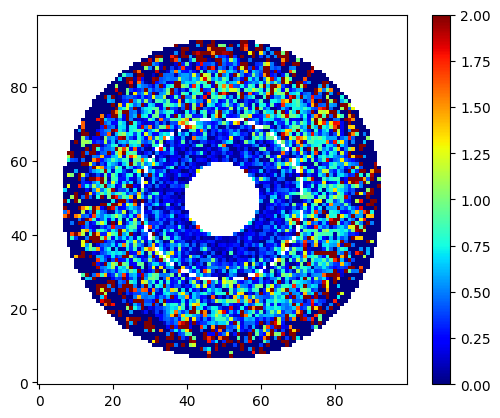

 >> Example 3
 >> Original image:


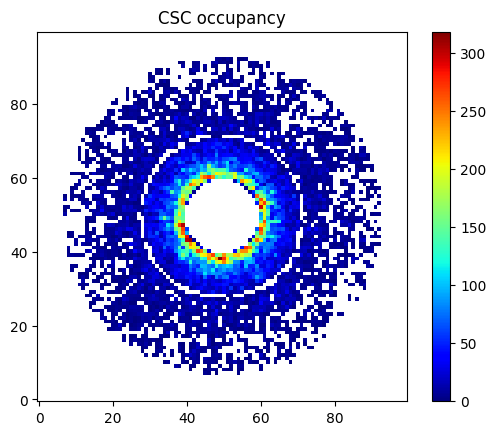

 >> AE-reco image:


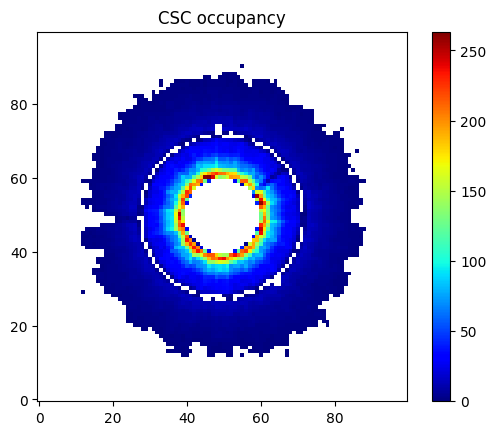

 >> Normalized loss map:


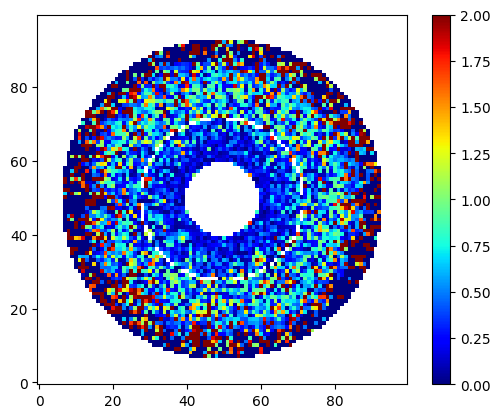

***** batch 5 *****
 >> Example 0
 >> Original image:


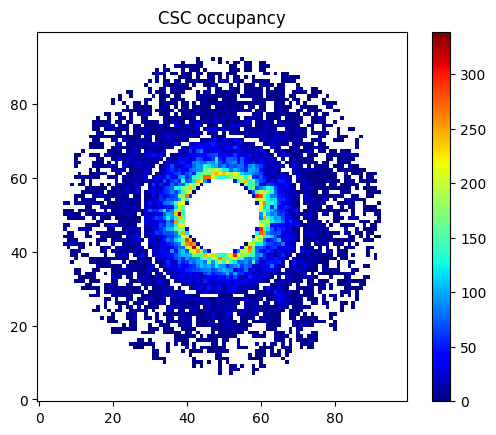

 >> AE-reco image:


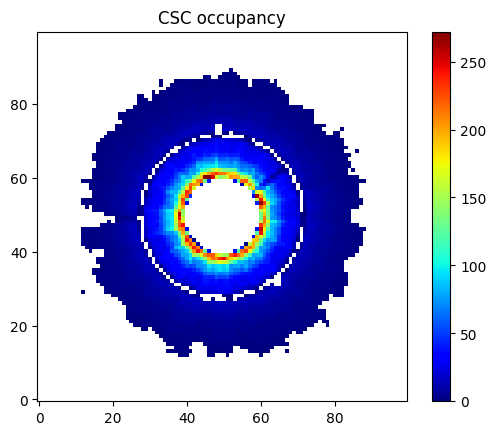

 >> Normalized loss map:


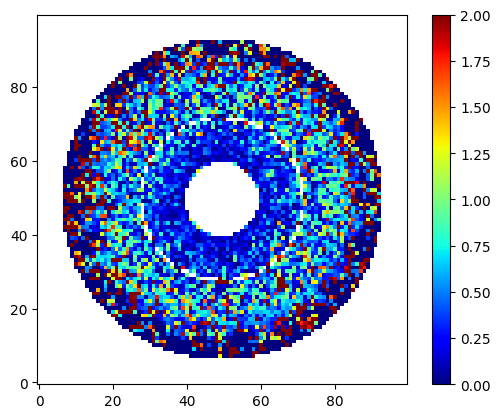

 >> Example 1
 >> Original image:


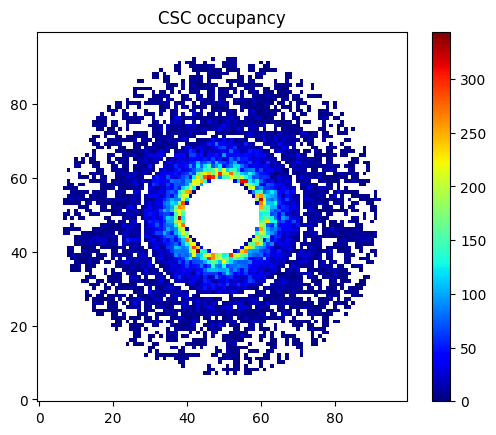

 >> AE-reco image:


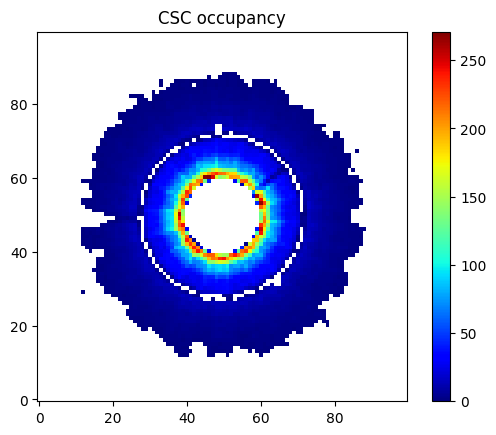

 >> Normalized loss map:


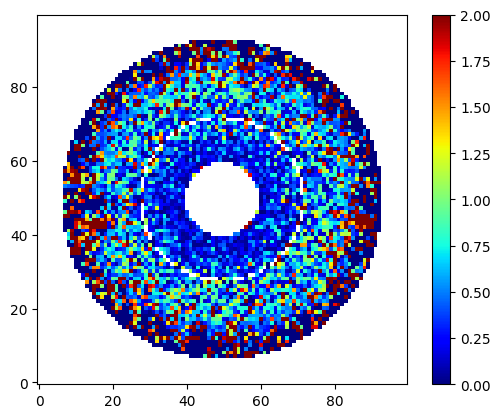

 >> Example 2
 >> Original image:


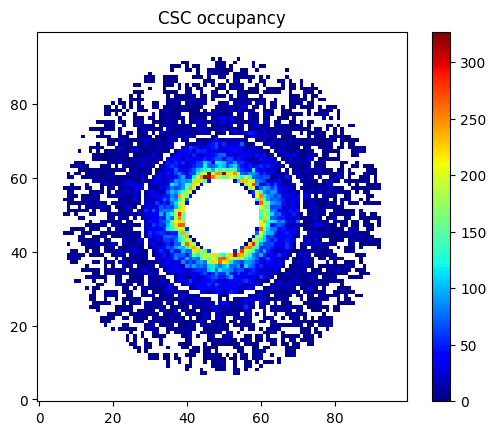

 >> AE-reco image:


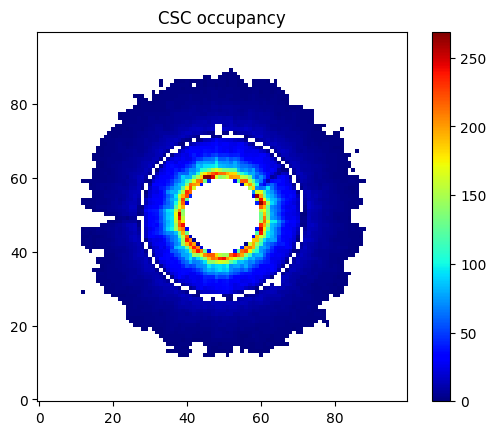

 >> Normalized loss map:


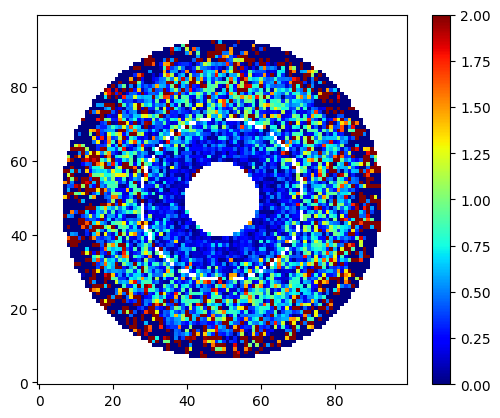

 >> Example 3
 >> Original image:


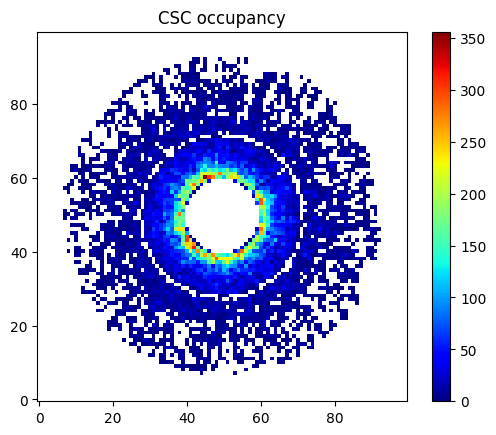

 >> AE-reco image:


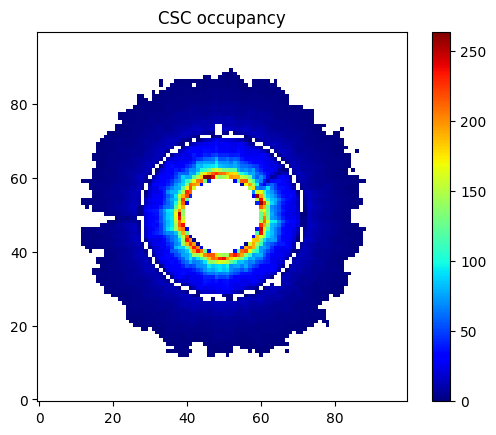

 >> Normalized loss map:


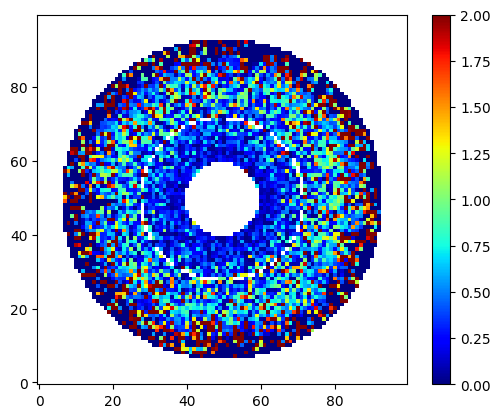

***** batch 6 *****
 >> Example 0
 >> Original image:


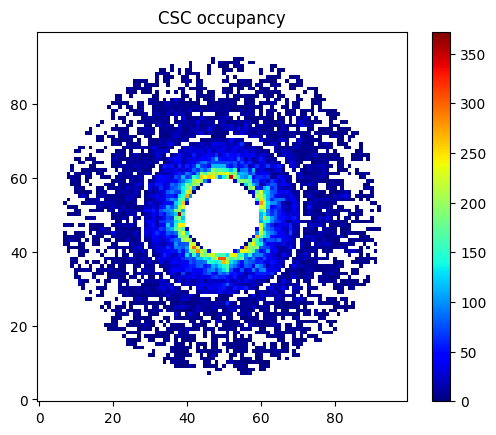

 >> AE-reco image:


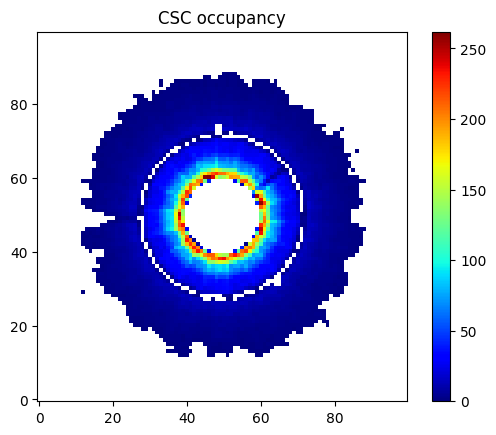

 >> Normalized loss map:


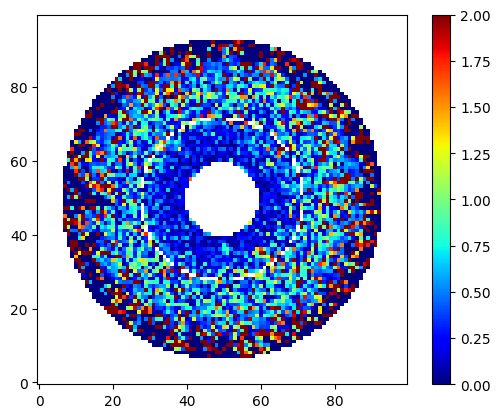

 >> Example 1
 >> Original image:


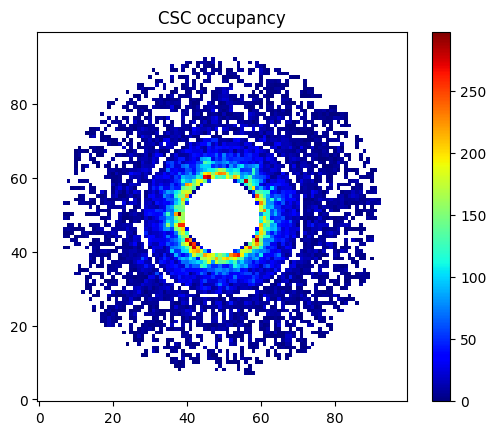

 >> AE-reco image:


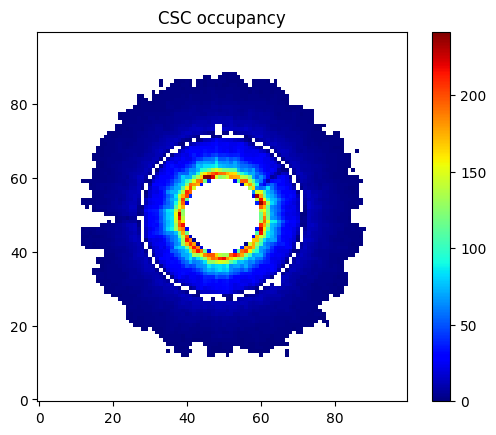

 >> Normalized loss map:


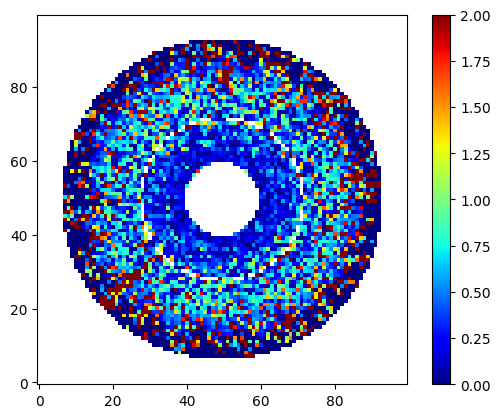

 >> Example 2
 >> Original image:


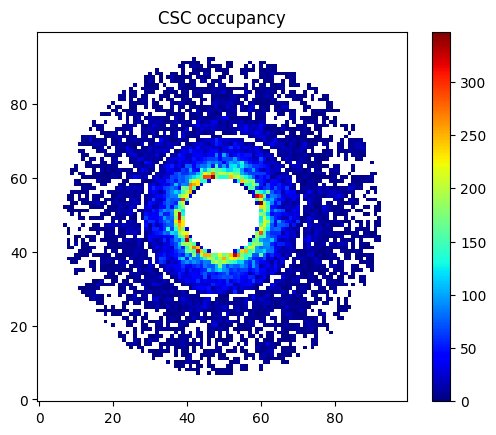

 >> AE-reco image:


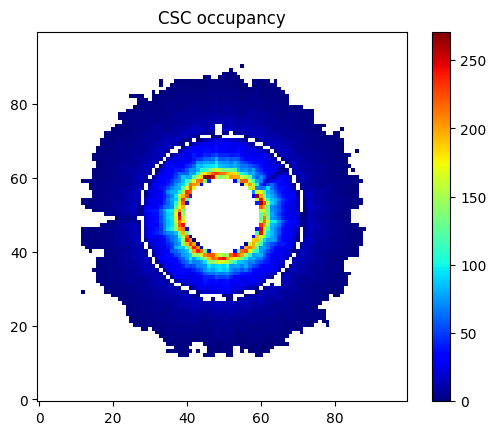

 >> Normalized loss map:


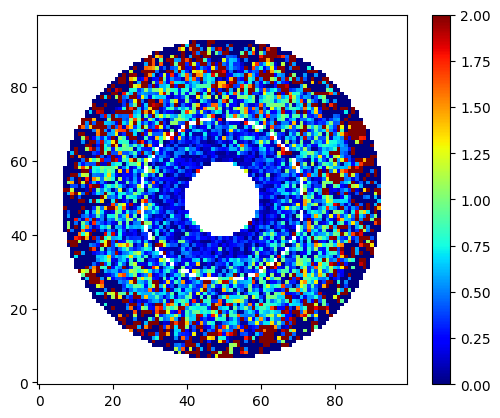

 >> Example 3
 >> Original image:


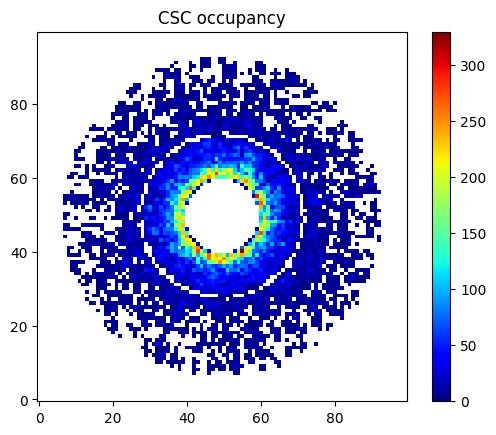

 >> AE-reco image:


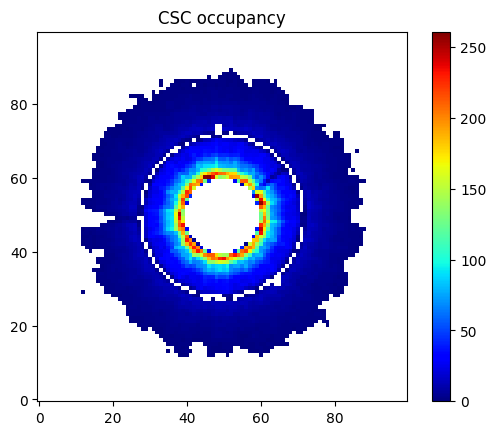

 >> Normalized loss map:


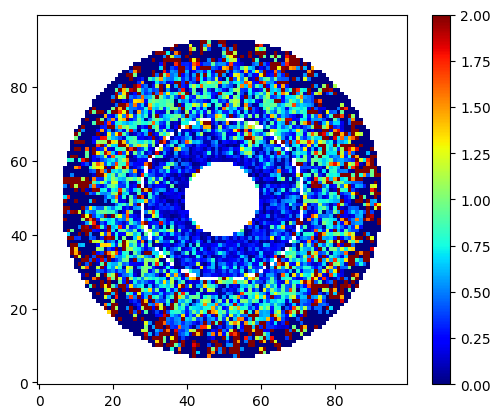

***** batch 7 *****
 >> Example 0
 >> Original image:


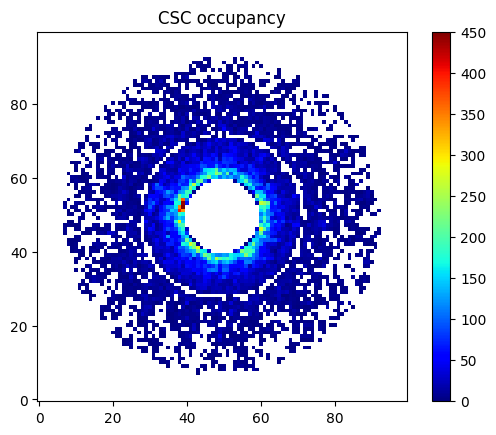

 >> AE-reco image:


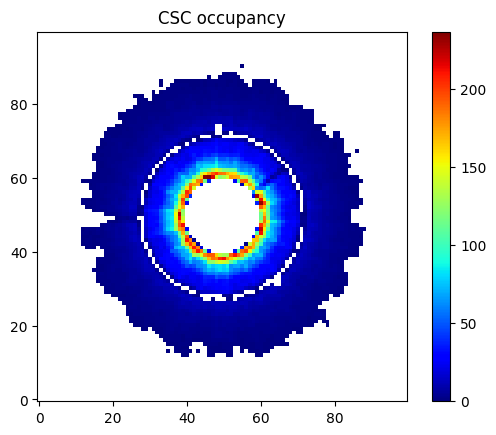

 >> Normalized loss map:


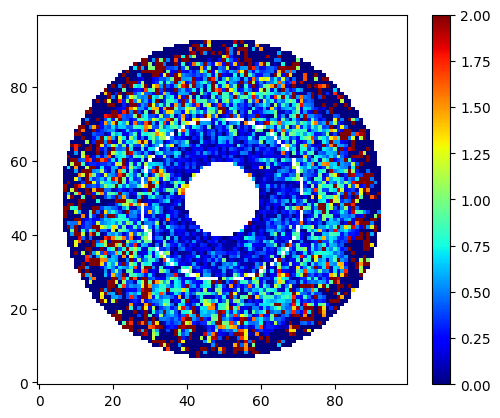

 >> Example 1
 >> Original image:


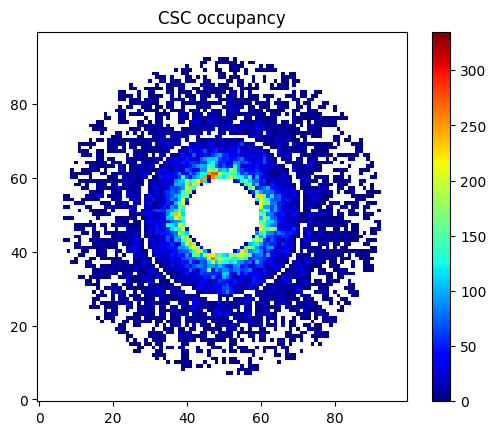

 >> AE-reco image:


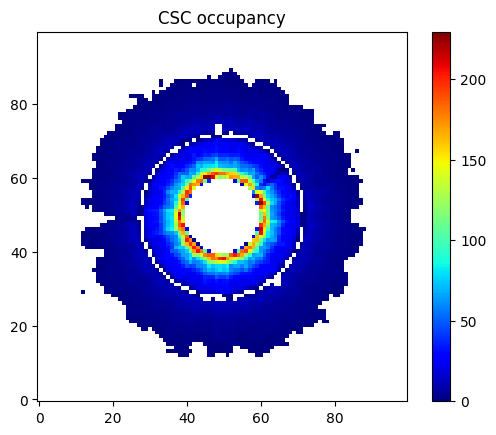

 >> Normalized loss map:


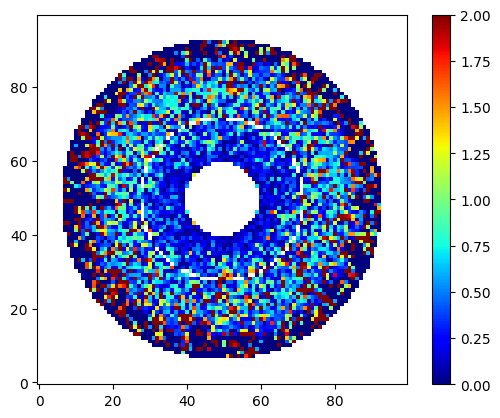

 >> Example 2
 >> Original image:


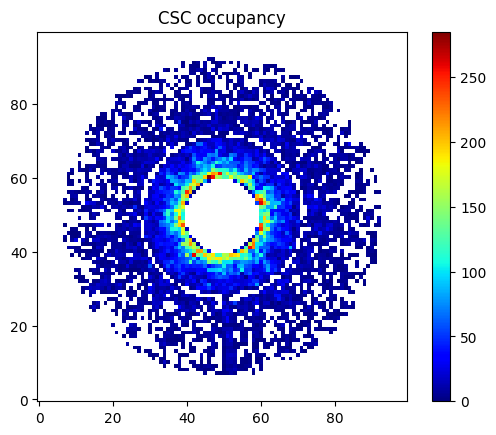

 >> AE-reco image:


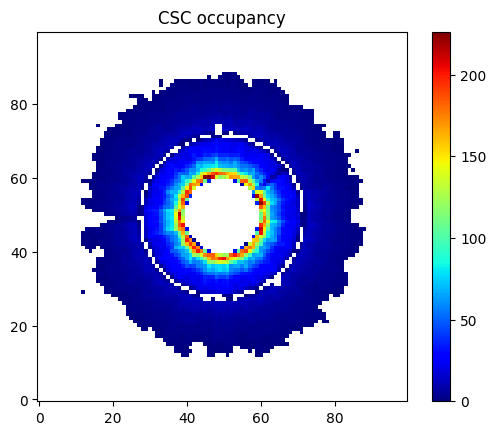

 >> Normalized loss map:


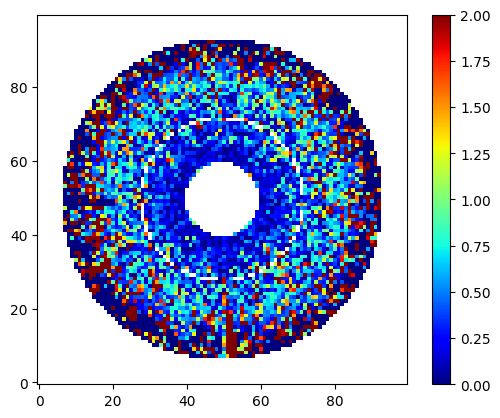

 >> Example 3
 >> Original image:


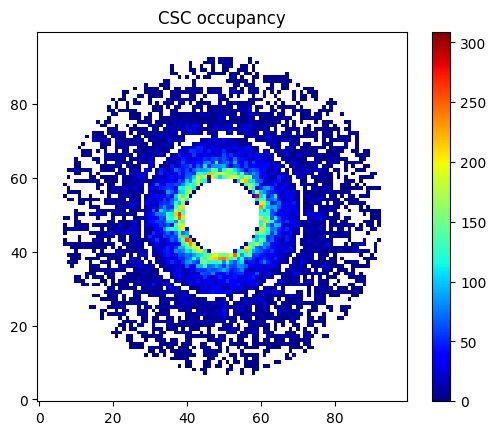

 >> AE-reco image:


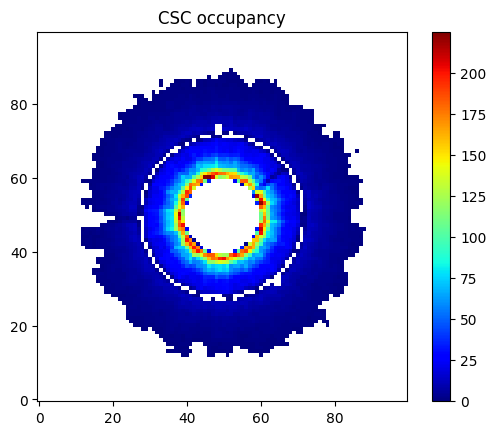

 >> Normalized loss map:


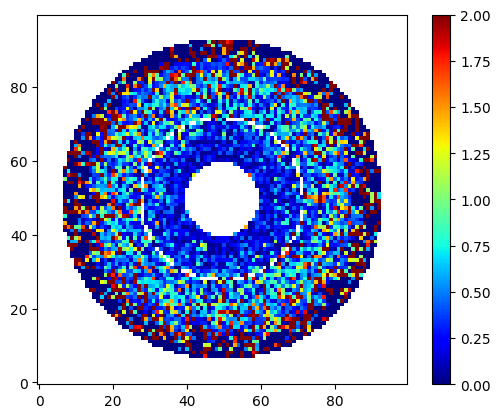

***** batch 8 *****
 >> Example 0
 >> Original image:


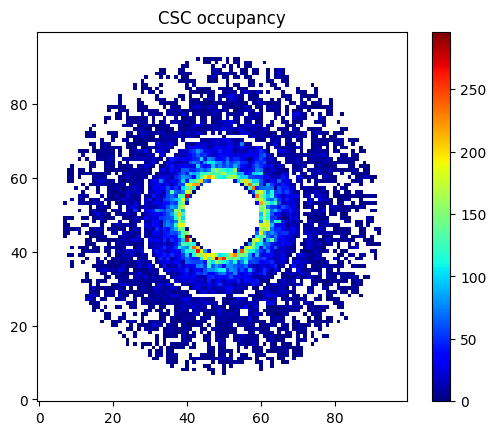

 >> AE-reco image:


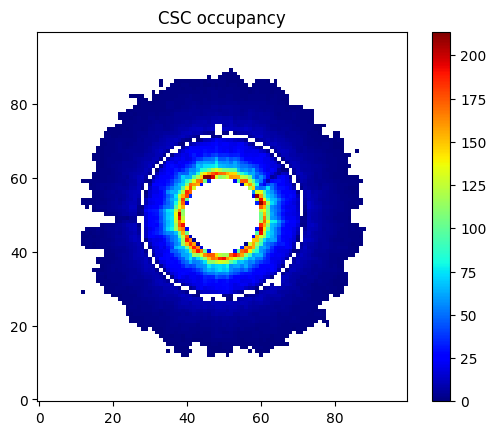

 >> Normalized loss map:


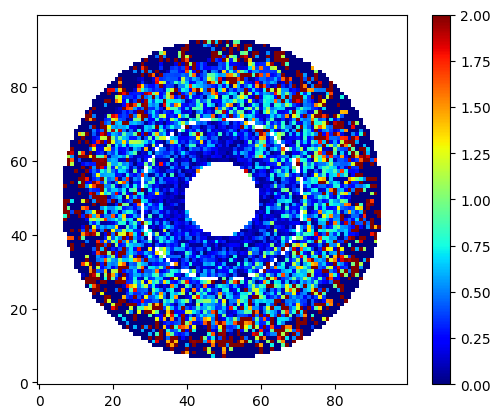

 >> Example 1
 >> Original image:


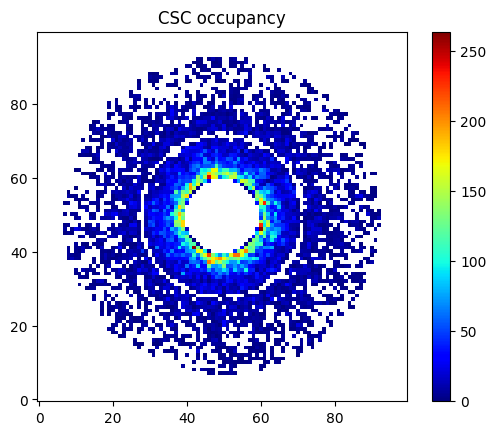

 >> AE-reco image:


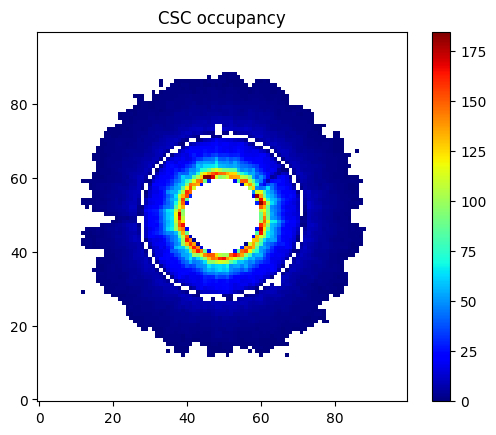

 >> Normalized loss map:


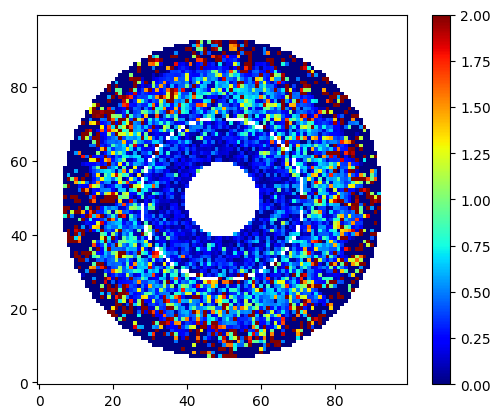

 >> Example 2
 >> Original image:


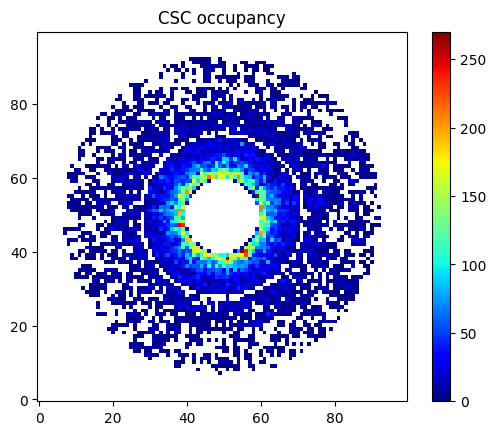

 >> AE-reco image:


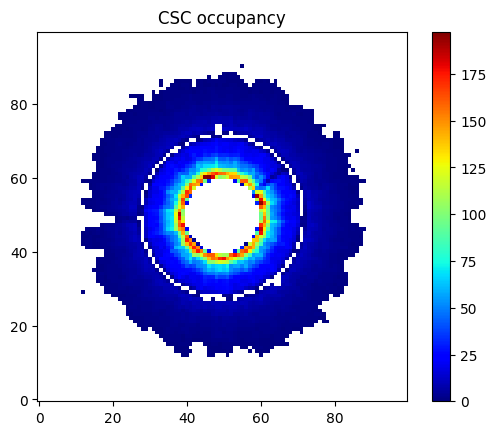

 >> Normalized loss map:


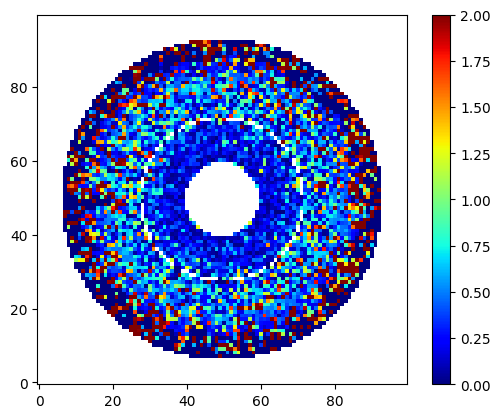

 >> Example 3
 >> Original image:


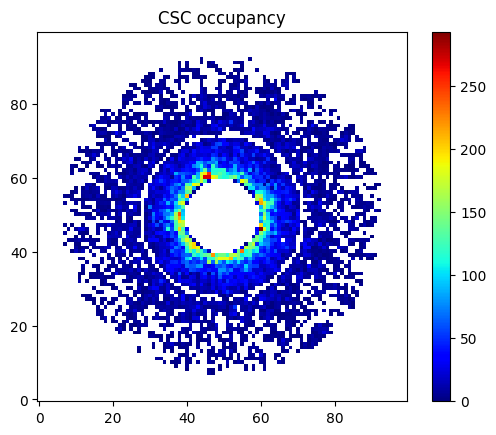

 >> AE-reco image:


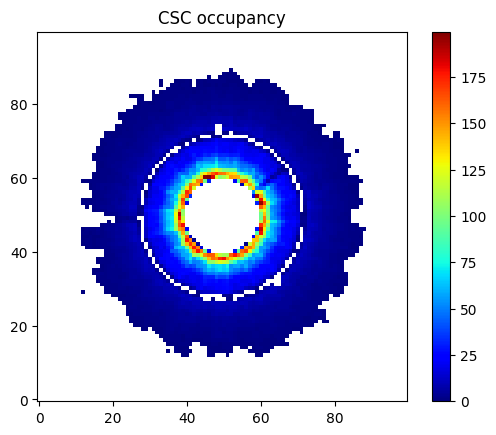

 >> Normalized loss map:


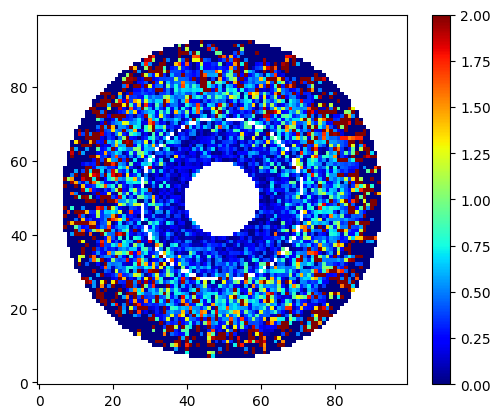

***** batch 9 *****
 >> Example 0
 >> Original image:


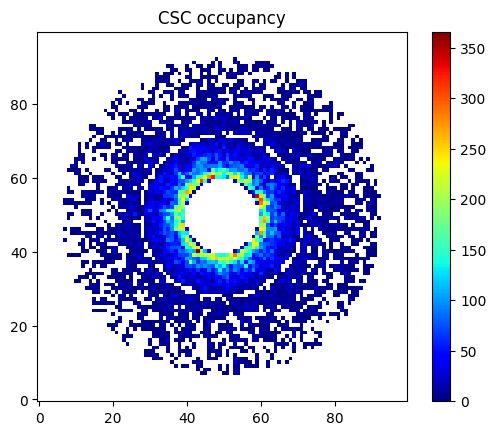

 >> AE-reco image:


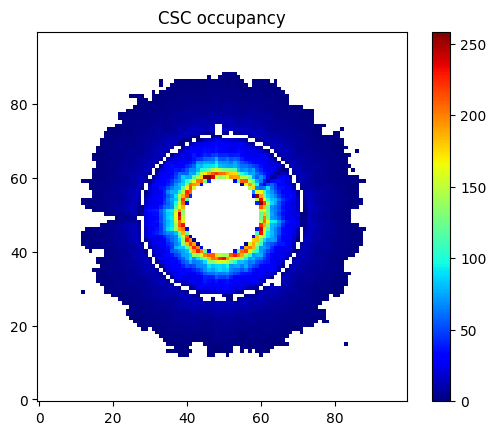

 >> Normalized loss map:


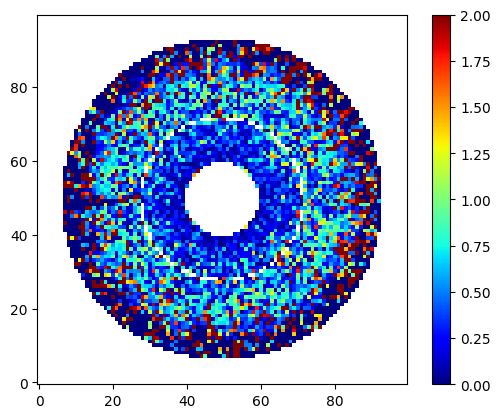

 >> Example 1
 >> Original image:


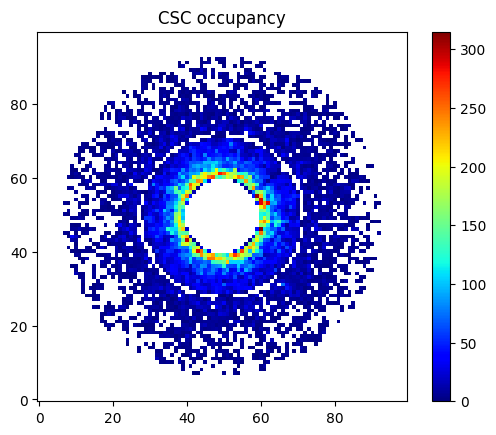

 >> AE-reco image:


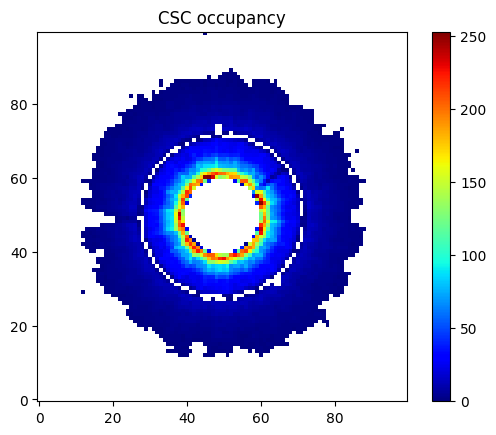

 >> Normalized loss map:


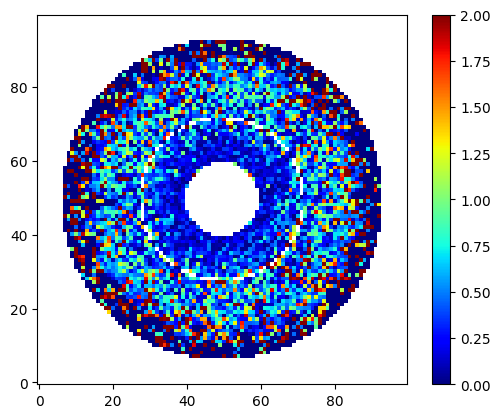

 >> Example 2
 >> Original image:


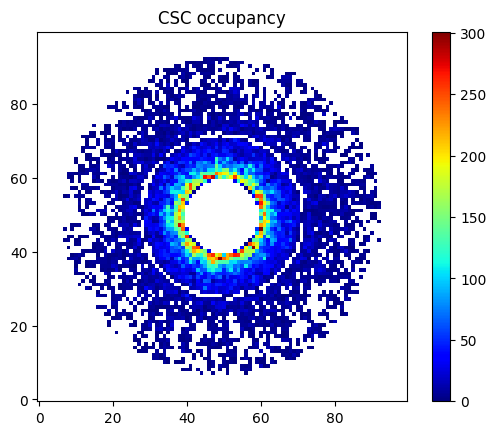

 >> AE-reco image:


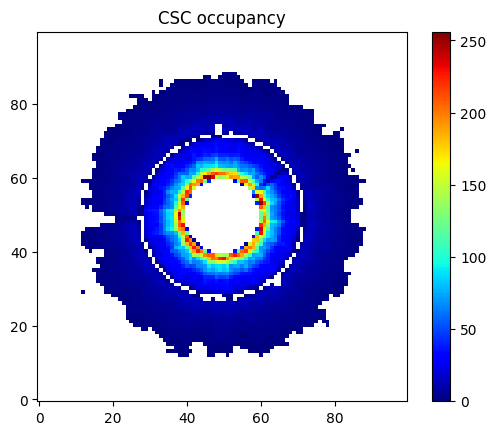

 >> Normalized loss map:


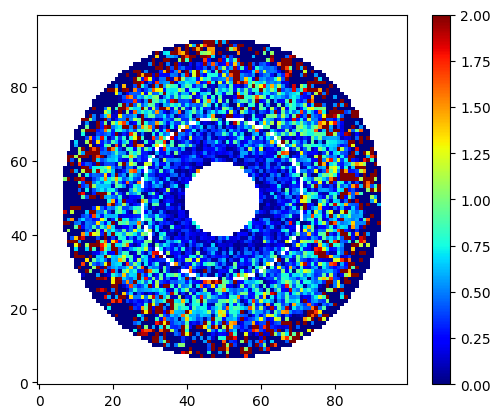

 >> Example 3
 >> Original image:


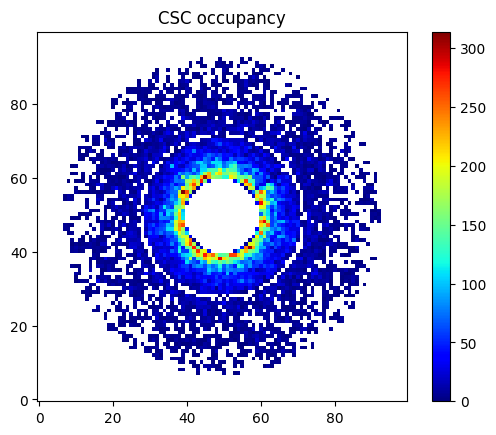

 >> AE-reco image:


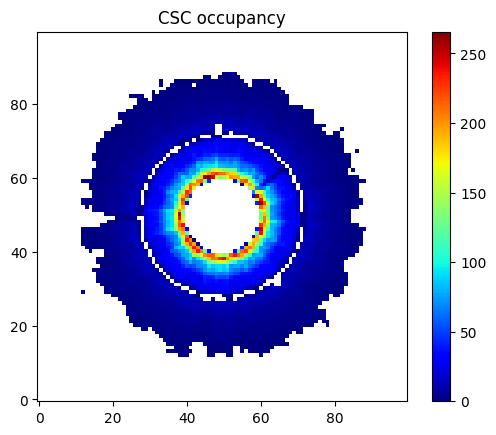

 >> Normalized loss map:


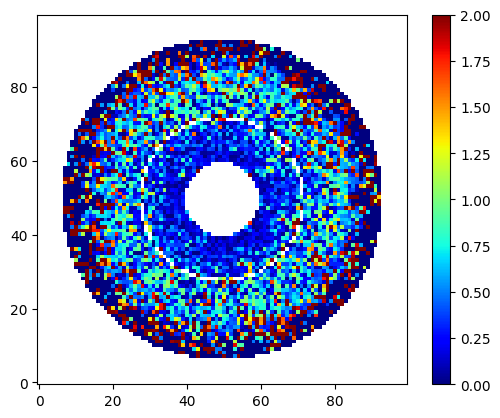

***** batch 10 *****
 >> Example 0
 >> Original image:


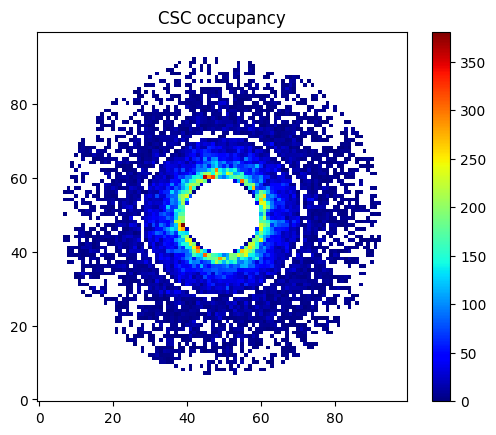

 >> AE-reco image:


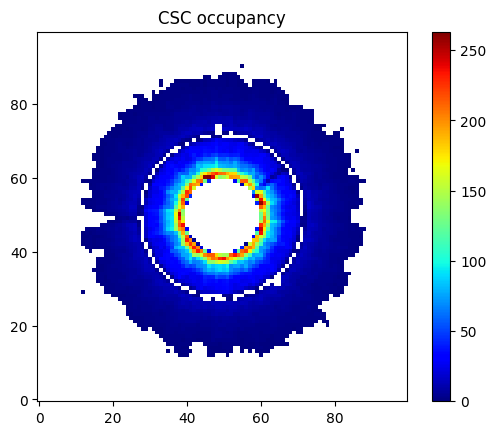

 >> Normalized loss map:


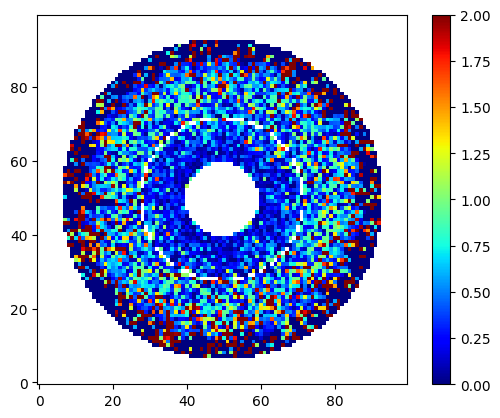

 >> Example 1
 >> Original image:


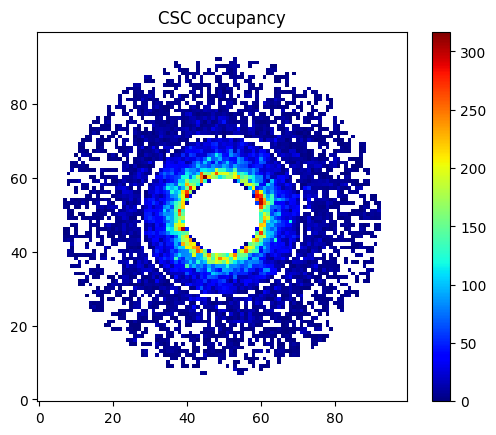

 >> AE-reco image:


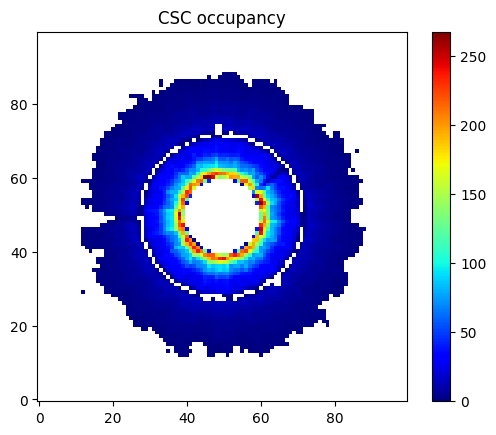

 >> Normalized loss map:


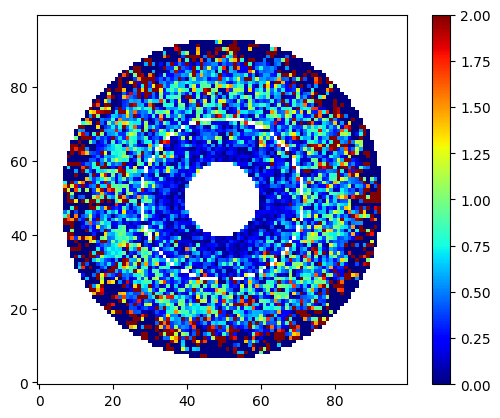

 >> Example 2
 >> Original image:


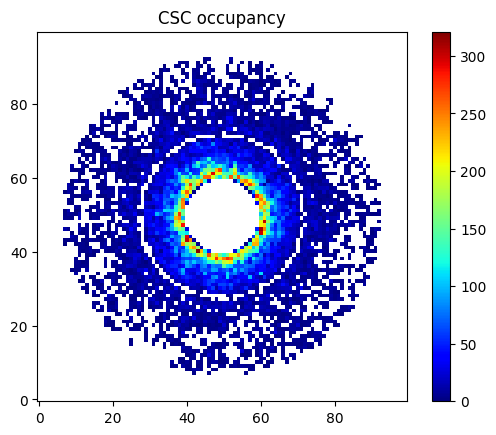

 >> AE-reco image:


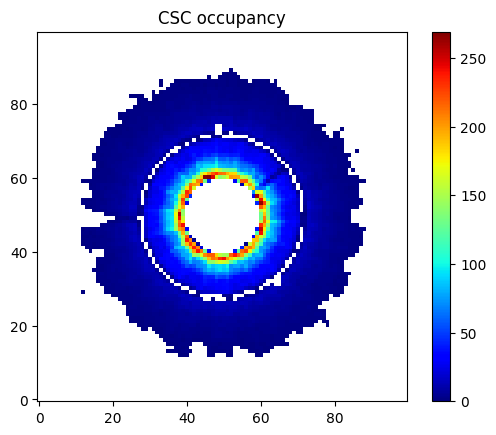

 >> Normalized loss map:


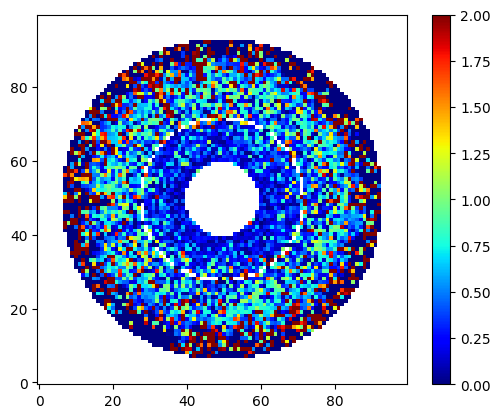

 >> Example 3
 >> Original image:


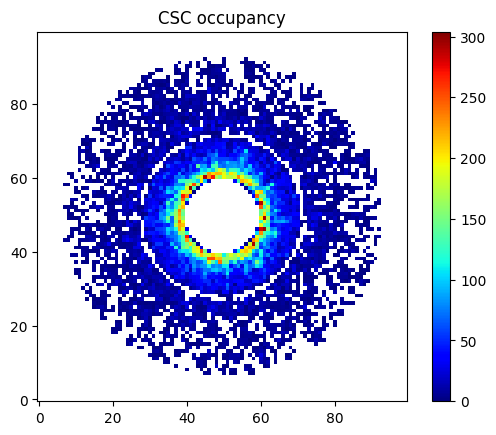

 >> AE-reco image:


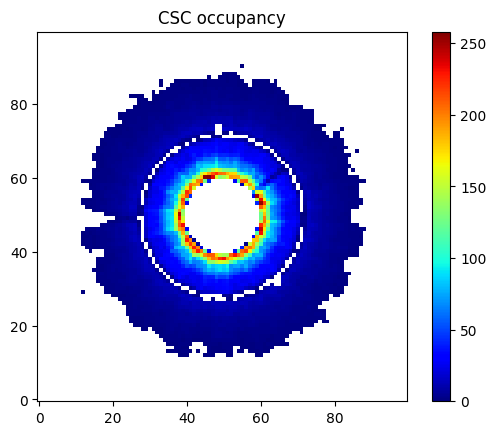

 >> Normalized loss map:


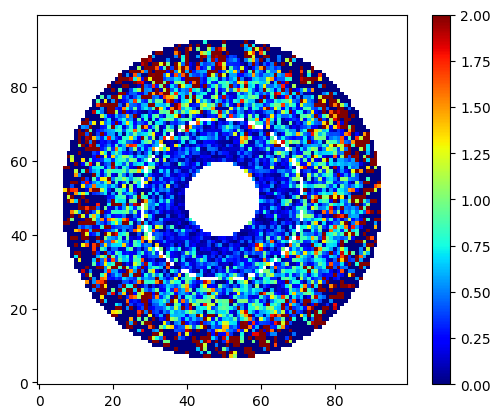

***** batch 11 *****
 >> Example 0
 >> Original image:


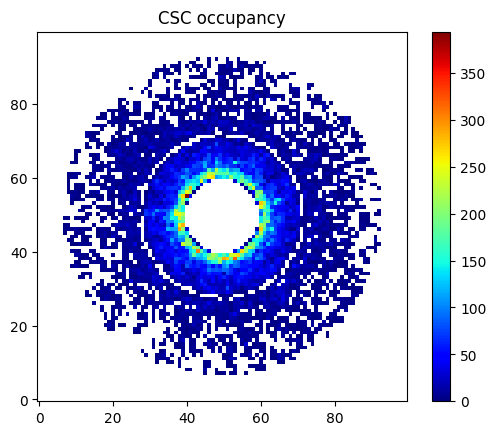

 >> AE-reco image:


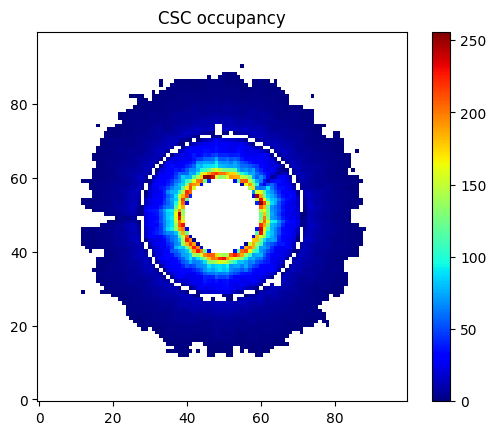

 >> Normalized loss map:


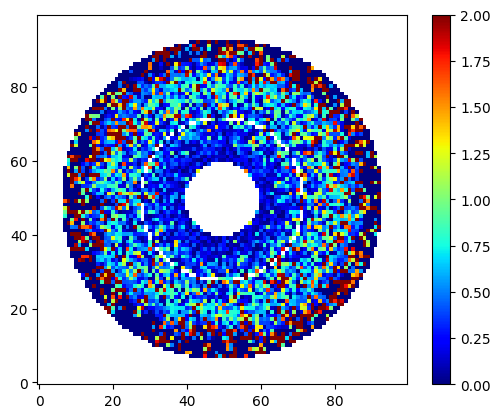

 >> Example 1
 >> Original image:


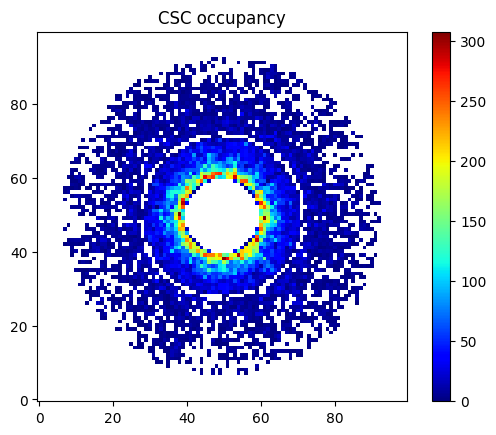

 >> AE-reco image:


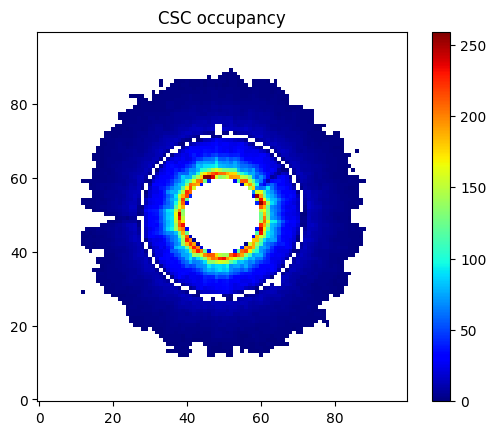

 >> Normalized loss map:


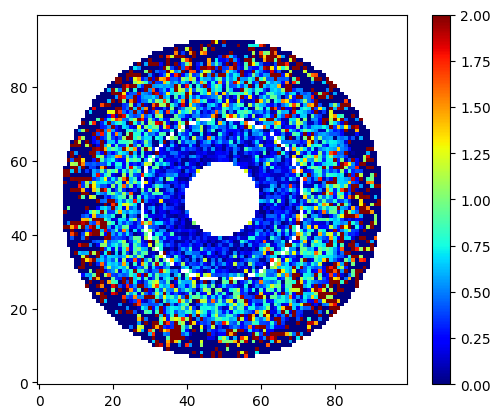

 >> Example 2
 >> Original image:


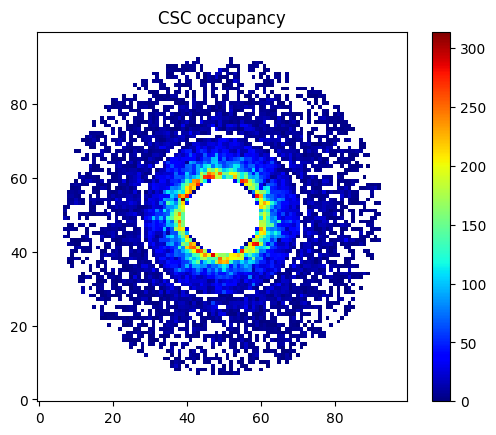

 >> AE-reco image:


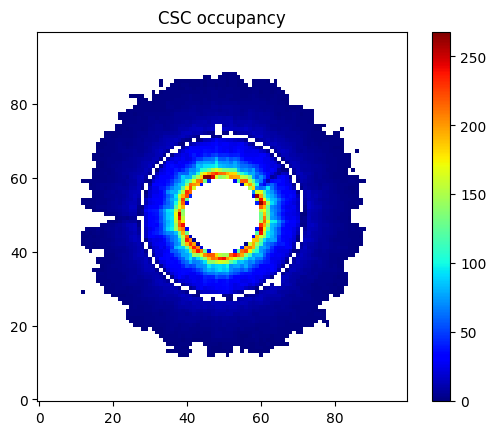

 >> Normalized loss map:


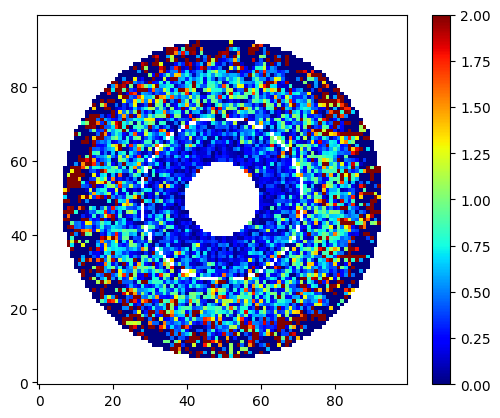

 >> Example 3
 >> Original image:


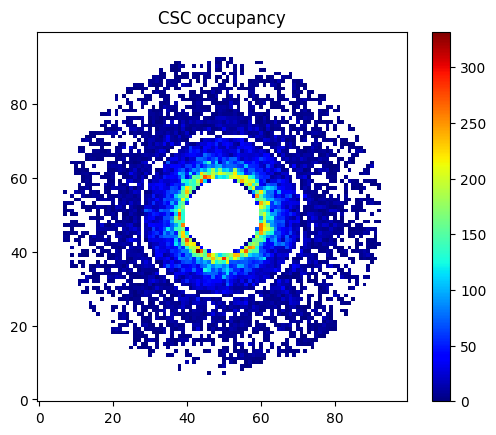

 >> AE-reco image:


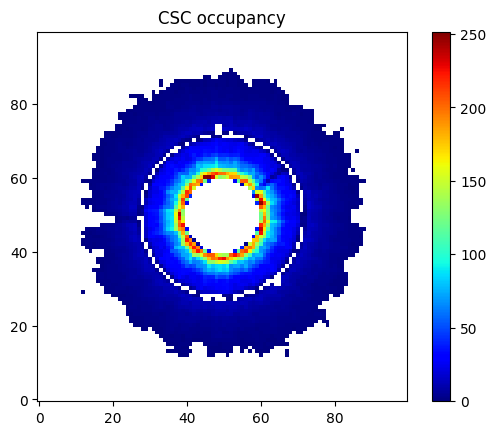

 >> Normalized loss map:


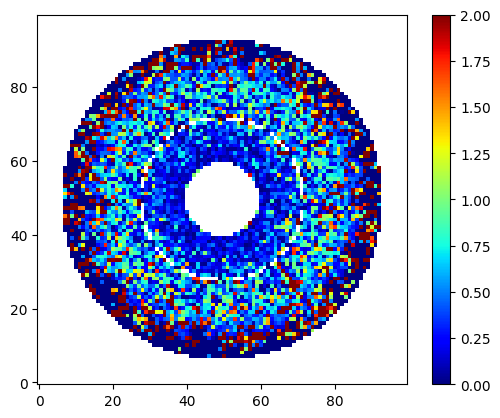

***** batch 12 *****
 >> Example 0
 >> Original image:


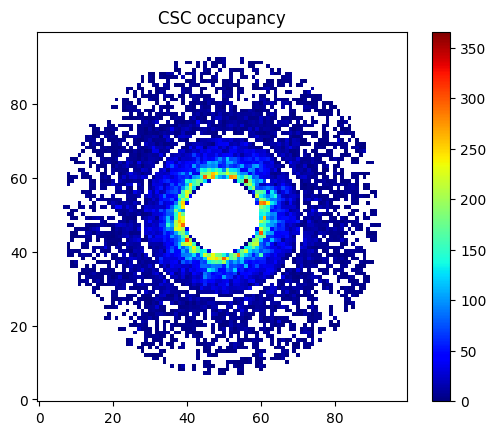

 >> AE-reco image:


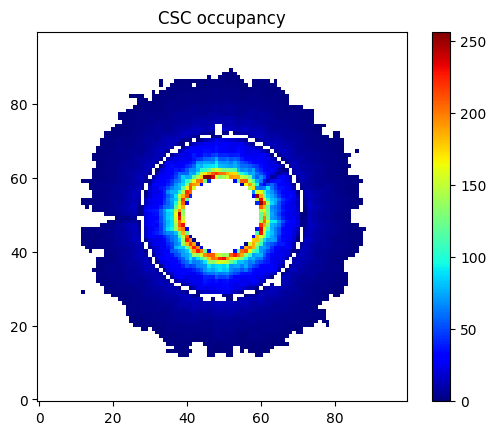

 >> Normalized loss map:


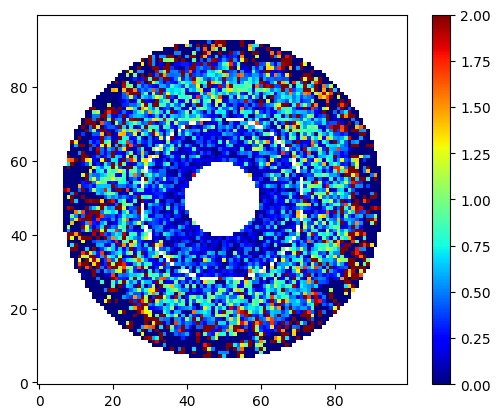

 >> Example 1
 >> Original image:


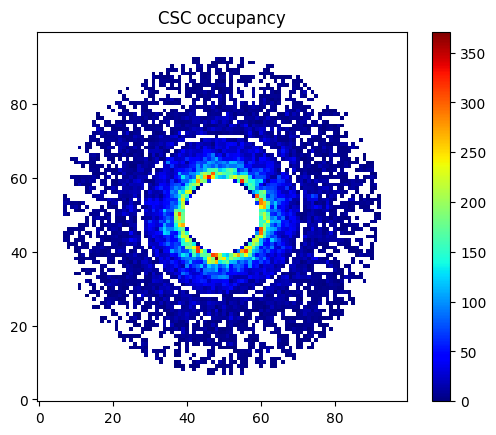

 >> AE-reco image:


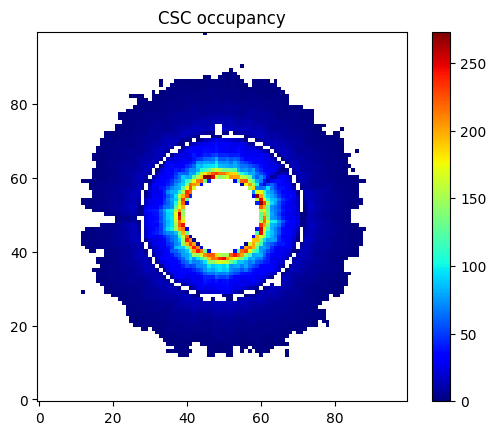

 >> Normalized loss map:


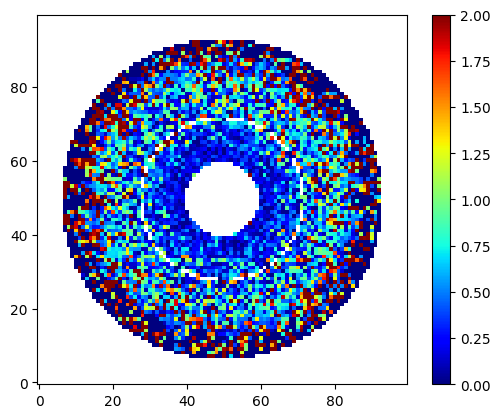

 >> Example 2
 >> Original image:


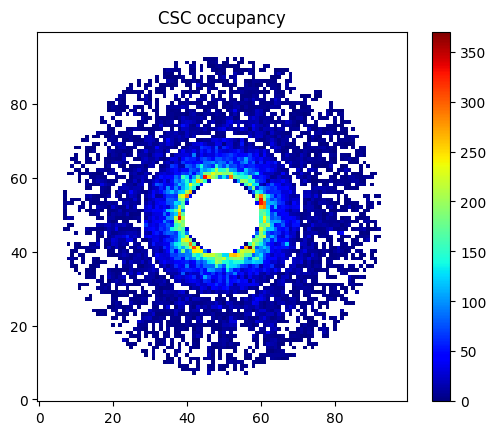

 >> AE-reco image:


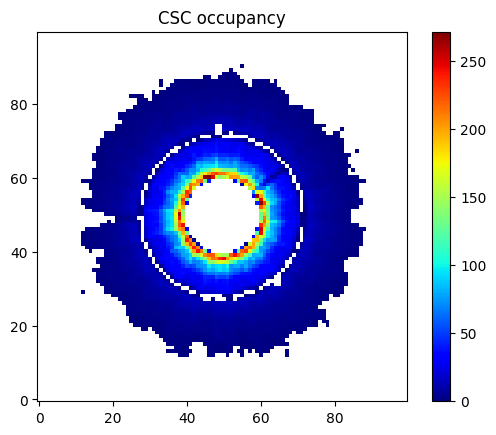

 >> Normalized loss map:


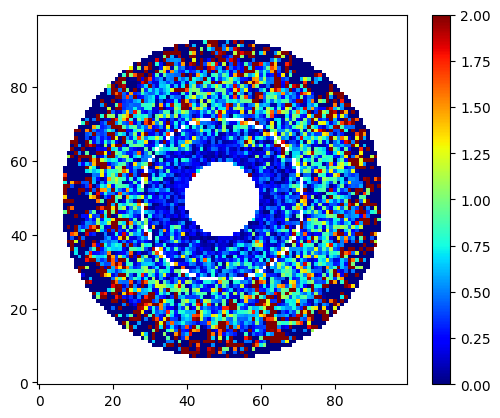

 >> Example 3
 >> Original image:


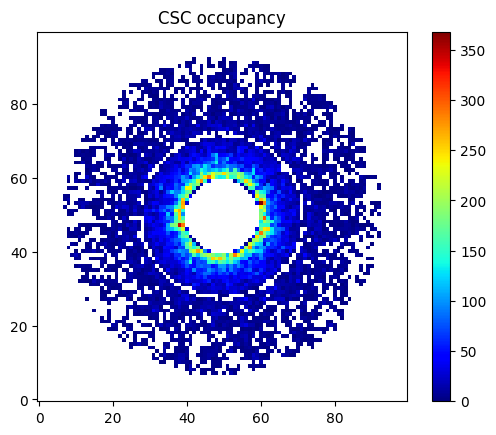

 >> AE-reco image:


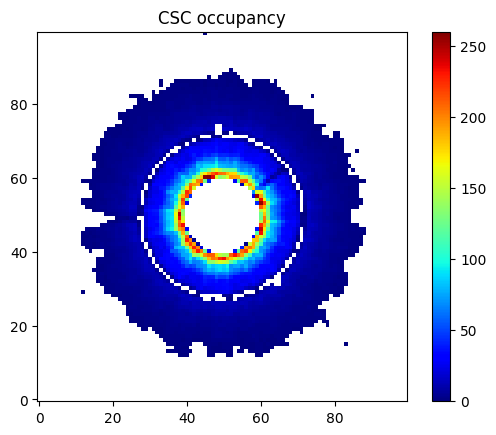

 >> Normalized loss map:


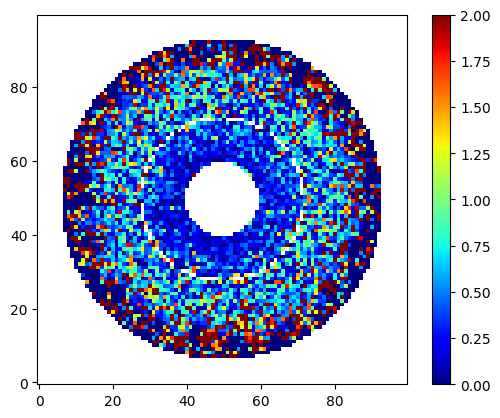

***** batch 13 *****
 >> Example 0
 >> Original image:


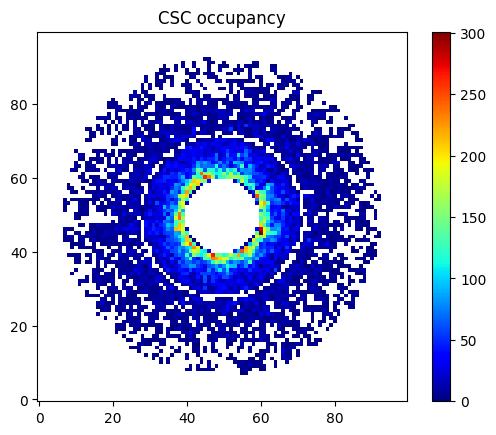

 >> AE-reco image:


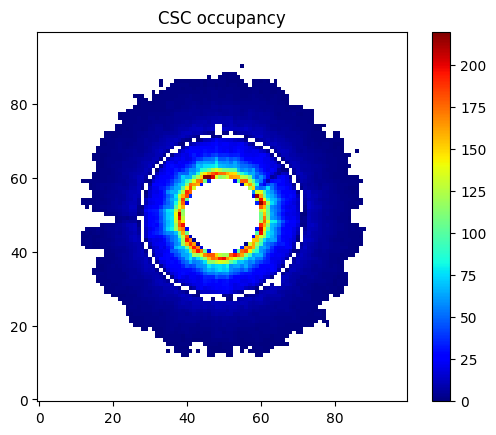

 >> Normalized loss map:


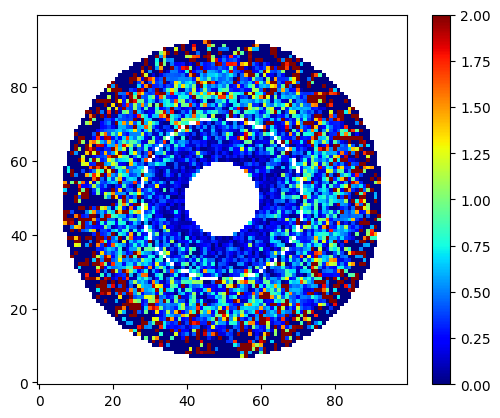

 >> Example 1
 >> Original image:


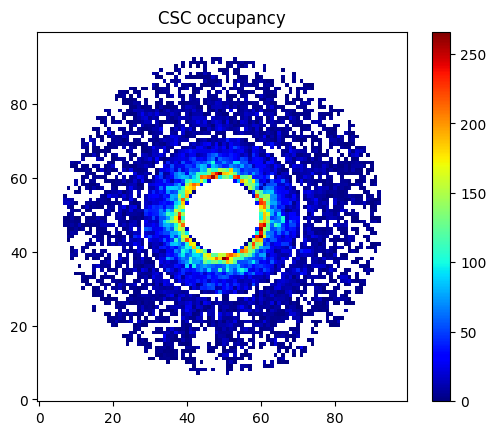

 >> AE-reco image:


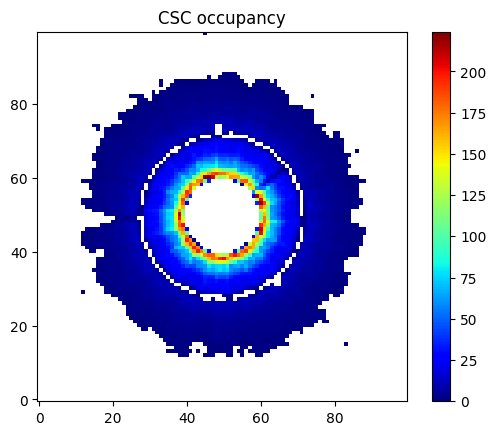

 >> Normalized loss map:


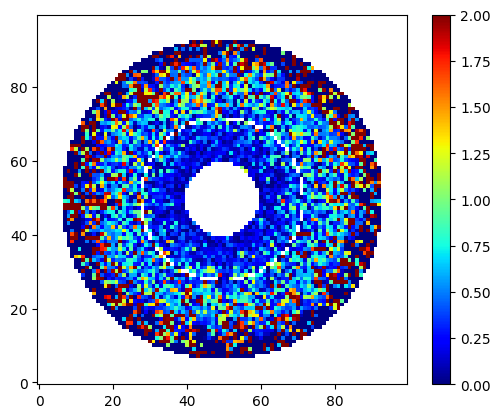

 >> Example 2
 >> Original image:


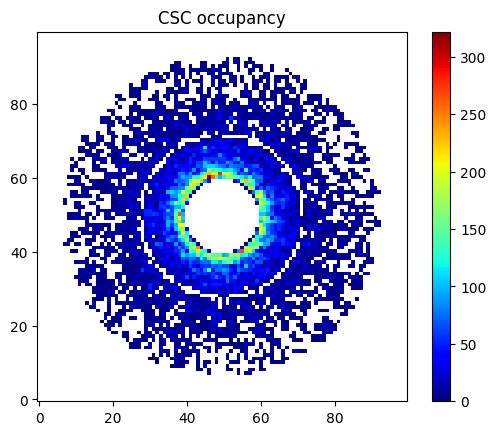

 >> AE-reco image:


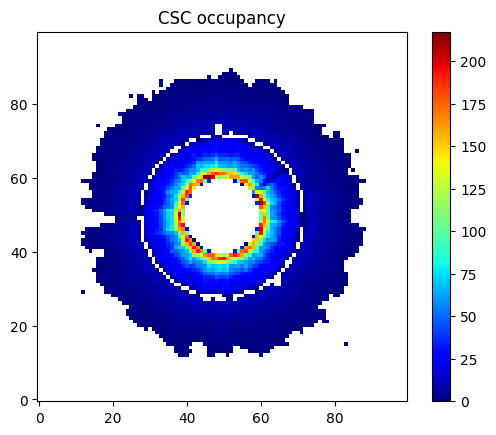

 >> Normalized loss map:


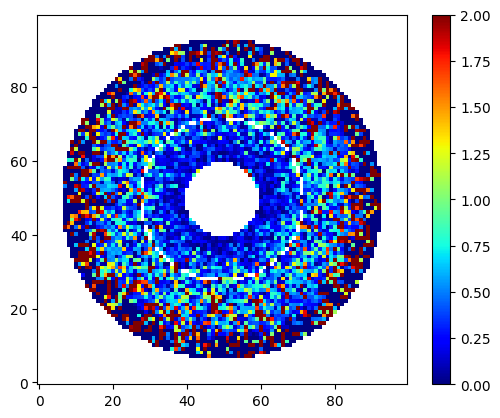

 >> Example 3
 >> Original image:


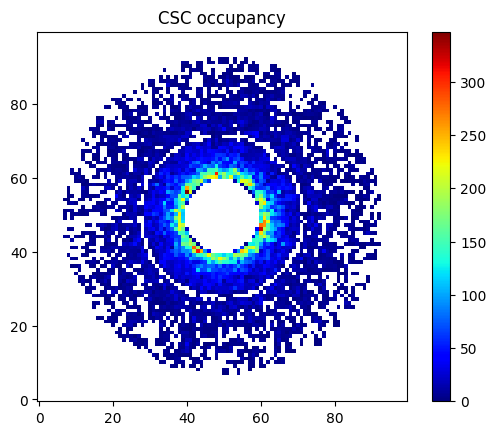

 >> AE-reco image:


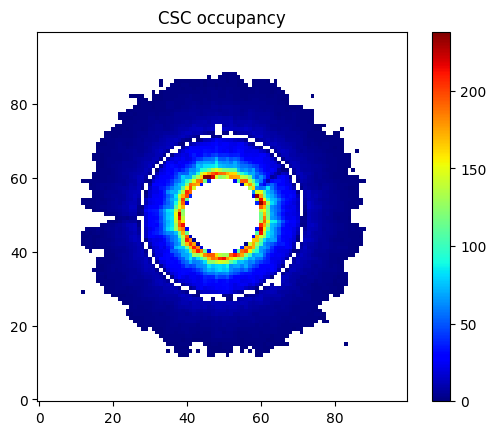

 >> Normalized loss map:


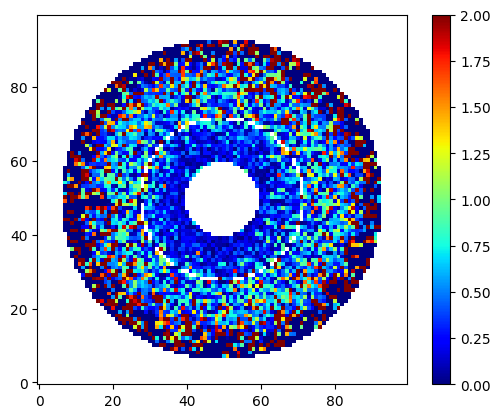

***** batch 14 *****
 >> Example 0
 >> Original image:


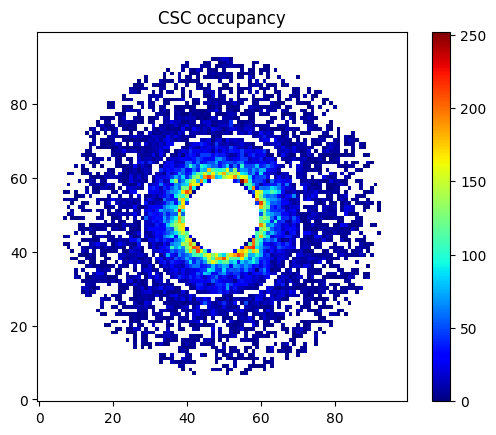

 >> AE-reco image:


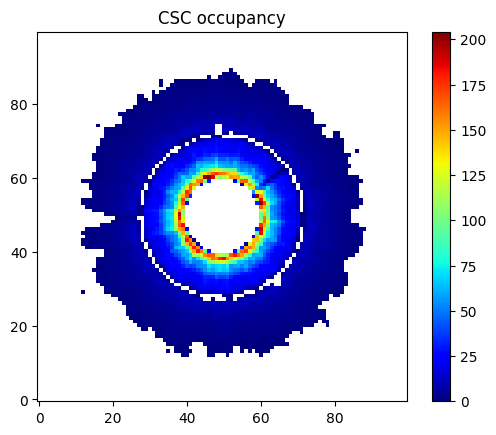

 >> Normalized loss map:


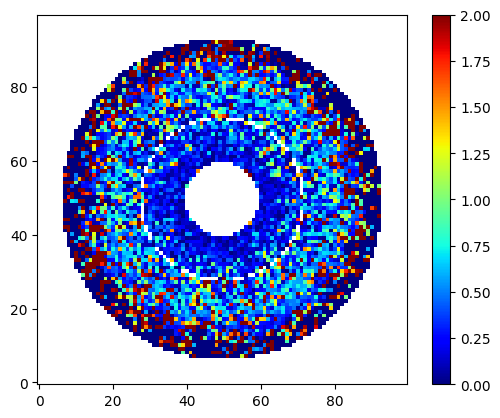

 >> Example 1
 >> Original image:


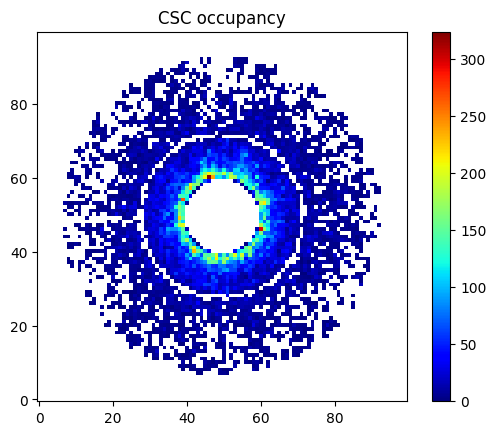

 >> AE-reco image:


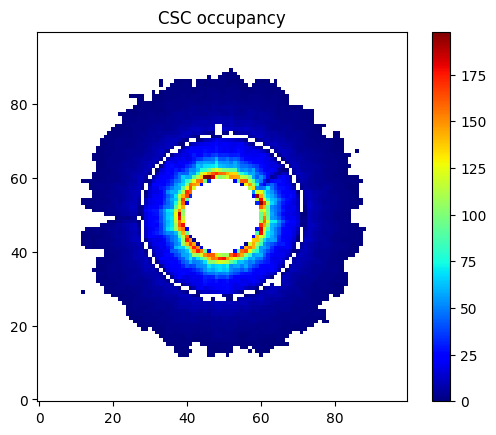

 >> Normalized loss map:


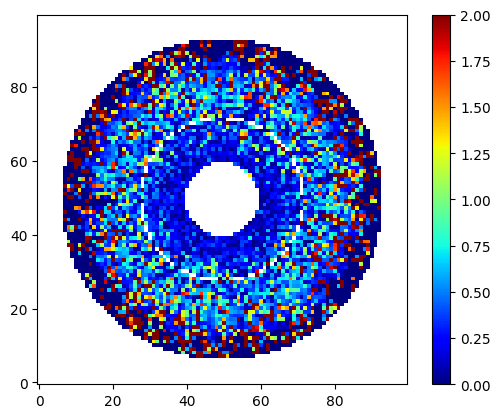

 >> Example 2
 >> Original image:


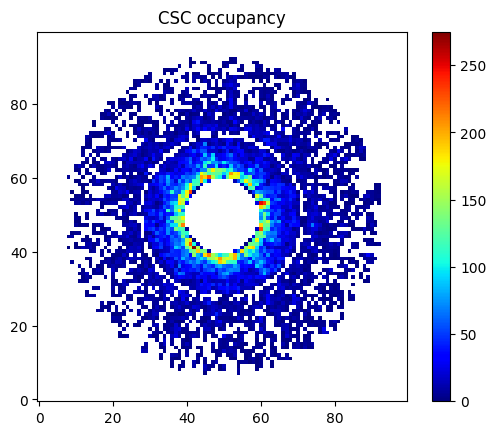

 >> AE-reco image:


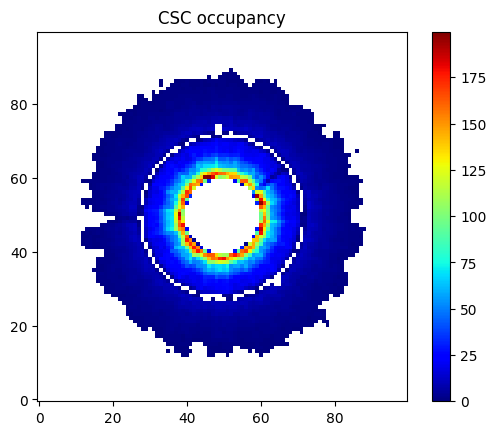

 >> Normalized loss map:


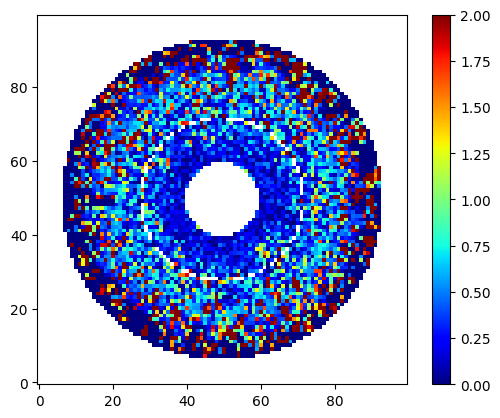

 >> Example 3
 >> Original image:


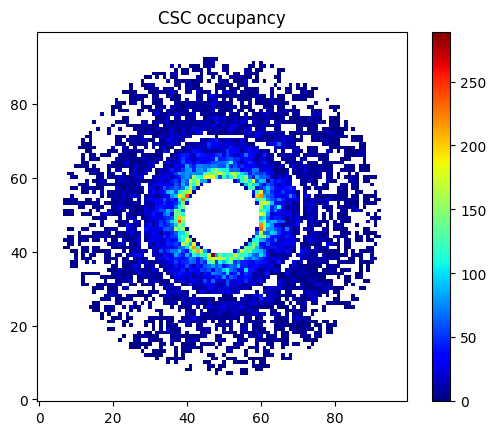

 >> AE-reco image:


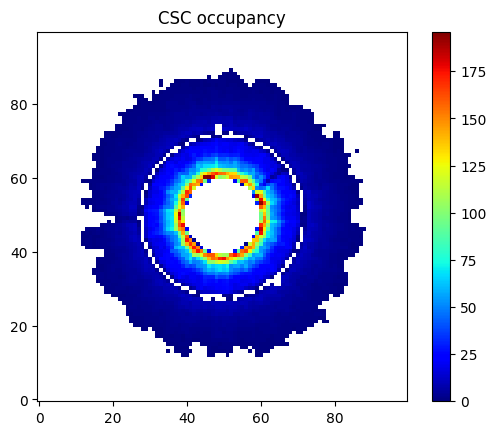

 >> Normalized loss map:


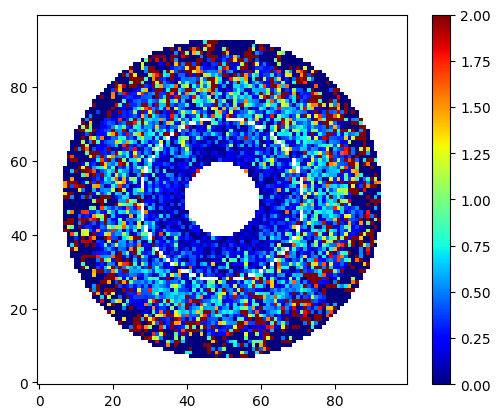

***** batch 15 *****
 >> Example 0
 >> Original image:


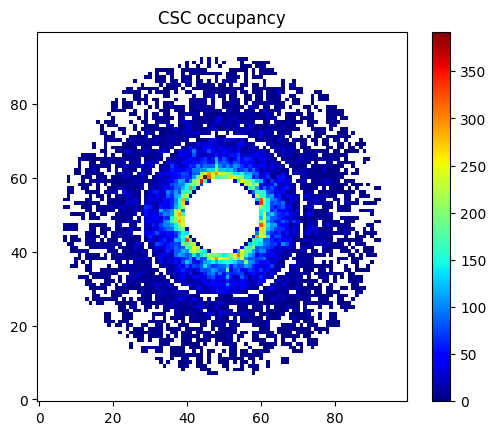

 >> AE-reco image:


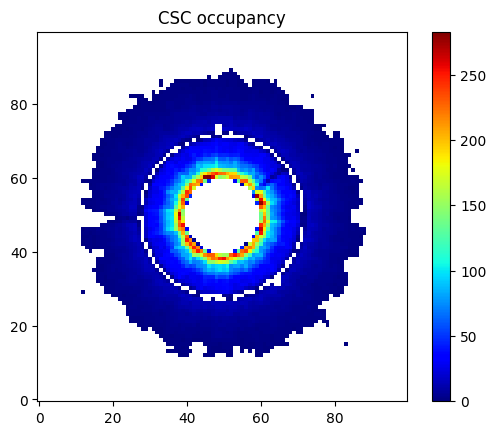

 >> Normalized loss map:


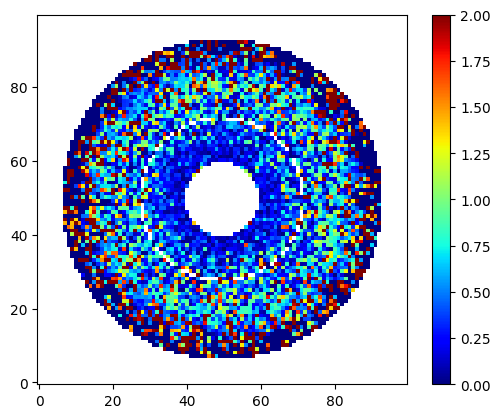

 >> Example 1
 >> Original image:


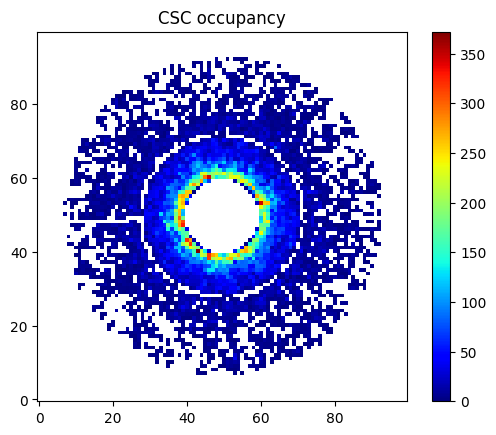

 >> AE-reco image:


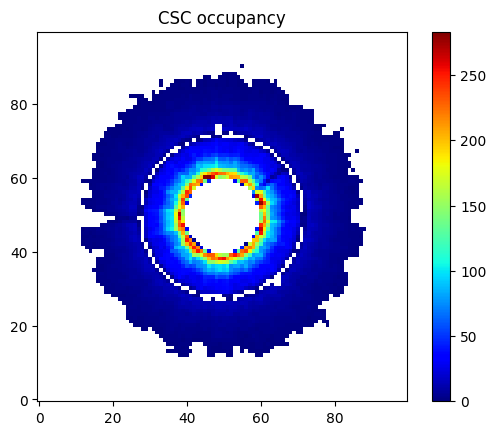

 >> Normalized loss map:


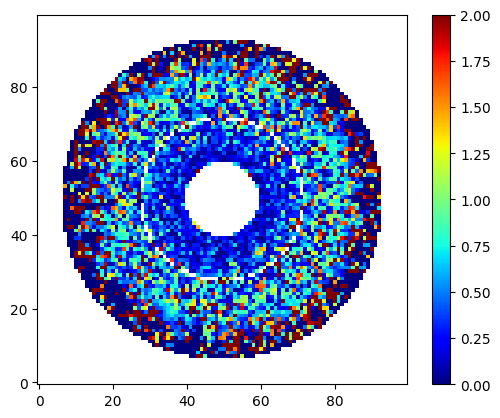

 >> Example 2
 >> Original image:


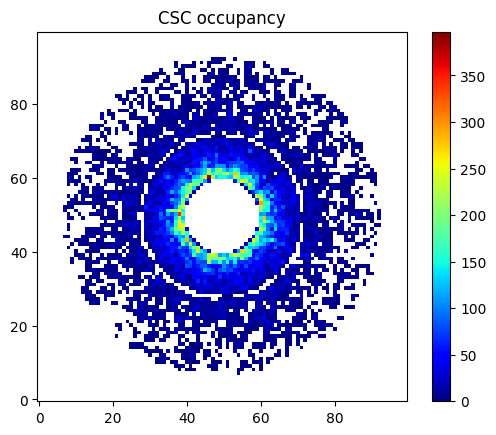

 >> AE-reco image:


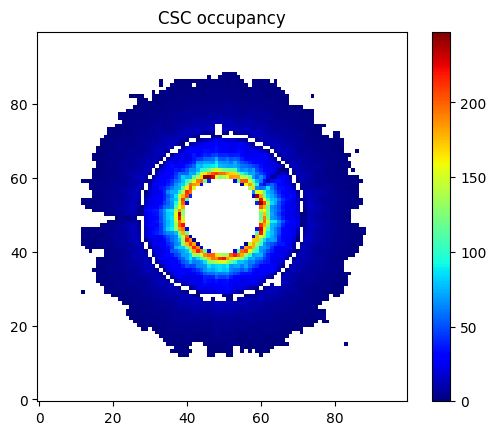

 >> Normalized loss map:


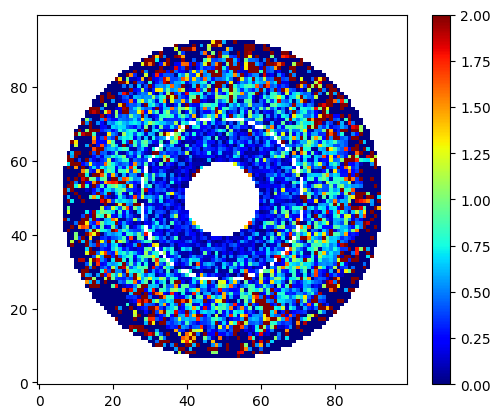

 >> Example 3
 >> Original image:


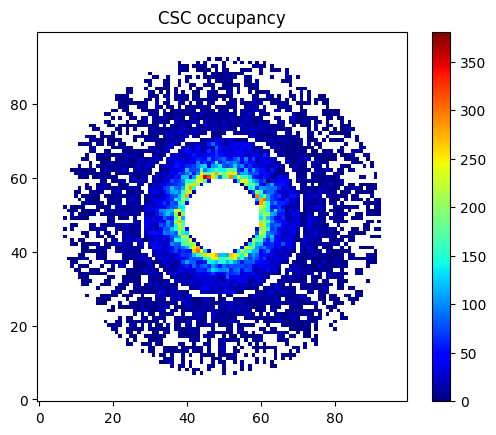

 >> AE-reco image:


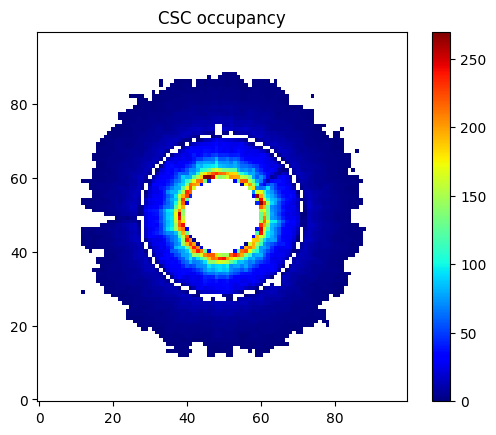

 >> Normalized loss map:


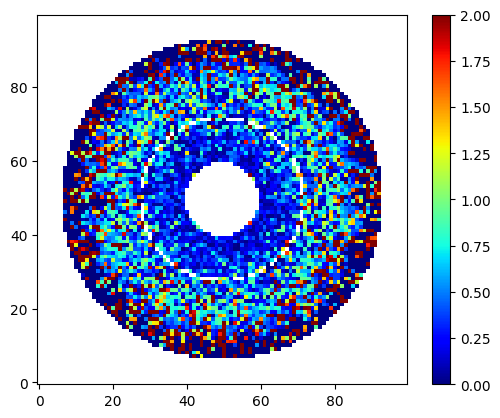

***** batch 16 *****
 >> Example 0
 >> Original image:


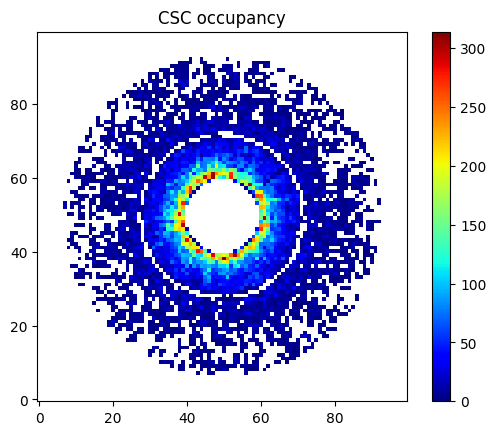

 >> AE-reco image:


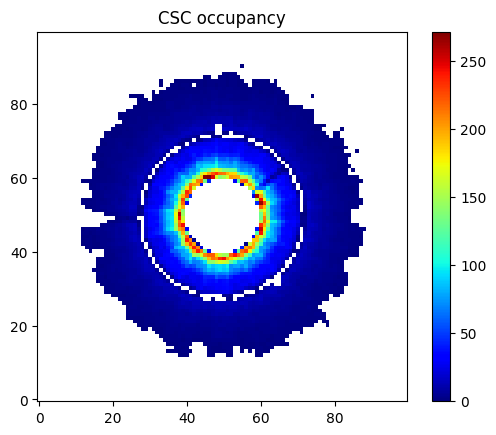

 >> Normalized loss map:


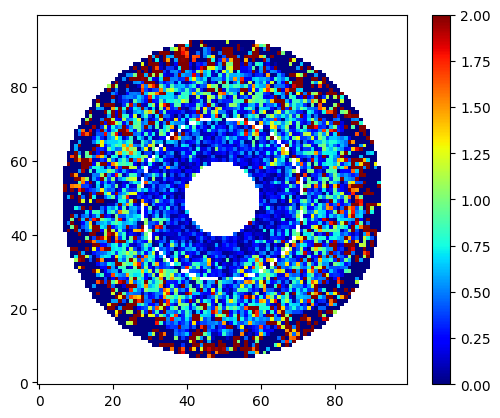

 >> Example 1
 >> Original image:


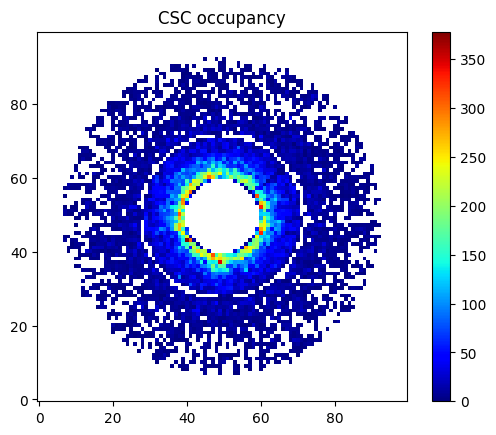

 >> AE-reco image:


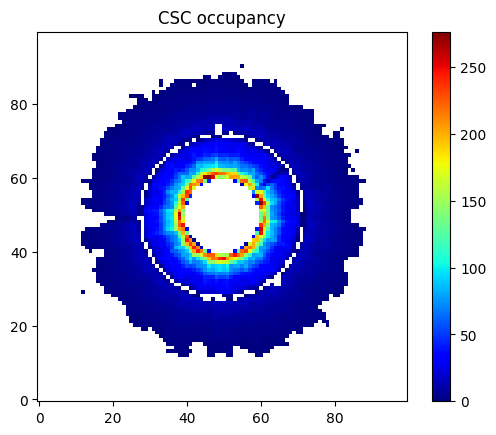

 >> Normalized loss map:


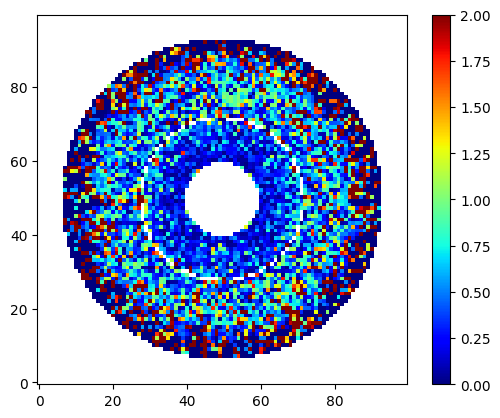

 >> Example 2
 >> Original image:


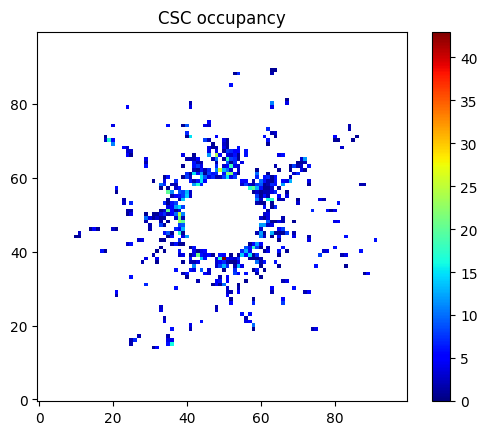

 >> AE-reco image:


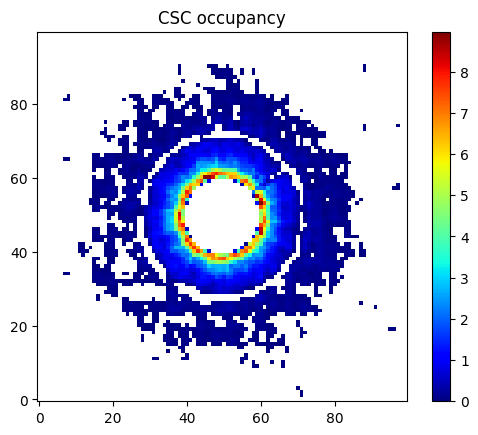

 >> Normalized loss map:


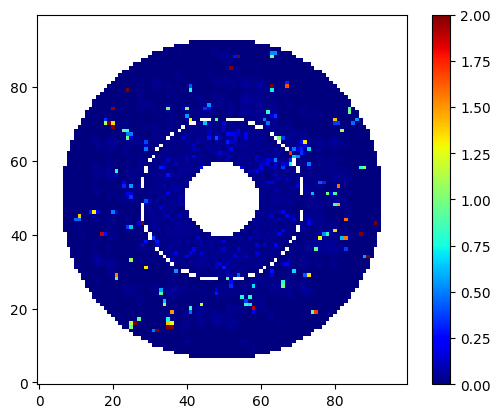

 >> Example 3
 >> Original image:


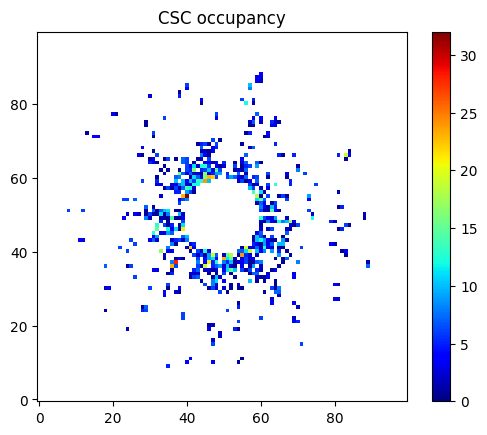

 >> AE-reco image:


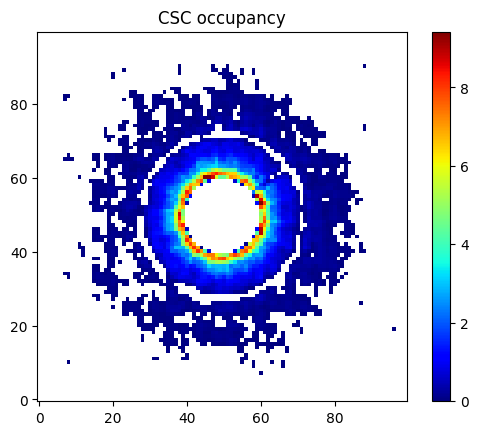

 >> Normalized loss map:


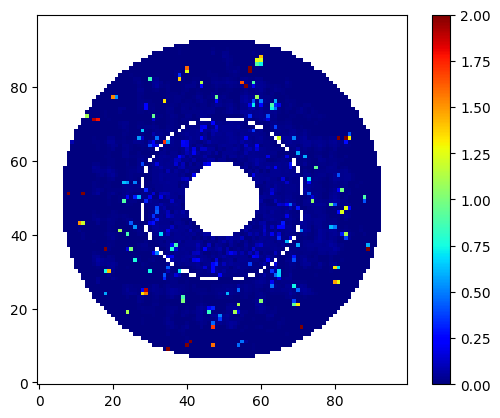

***** batch 17 *****
 >> Example 0
 >> Original image:


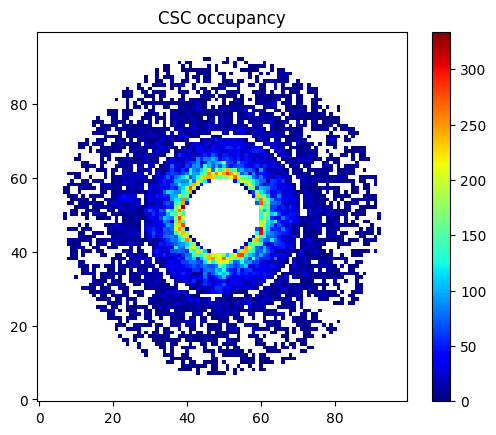

 >> AE-reco image:


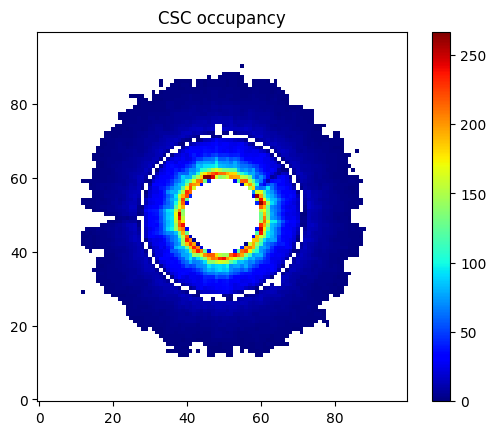

 >> Normalized loss map:


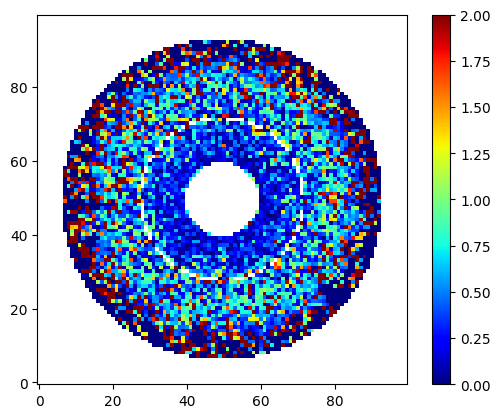

 >> Example 1
 >> Original image:


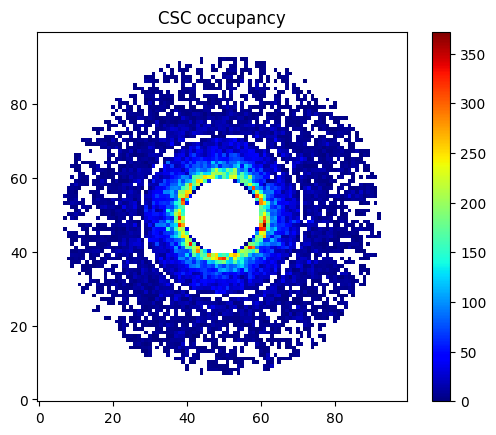

 >> AE-reco image:


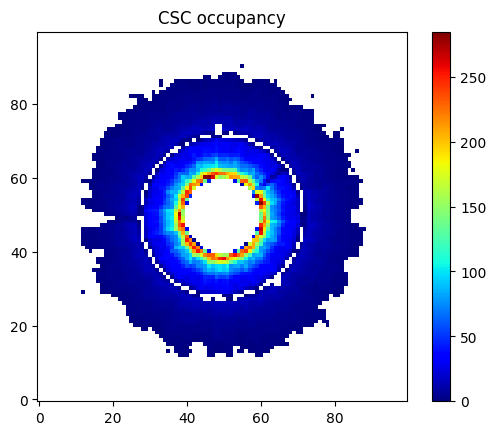

 >> Normalized loss map:


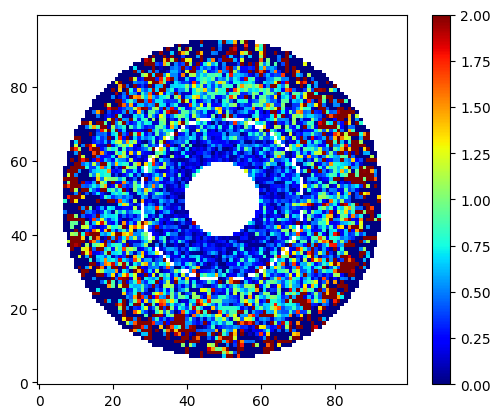

 >> Example 2
 >> Original image:


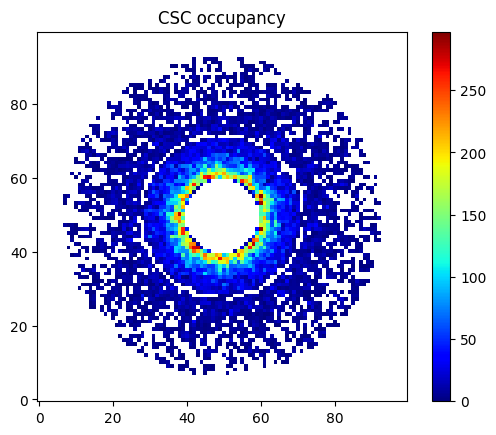

 >> AE-reco image:


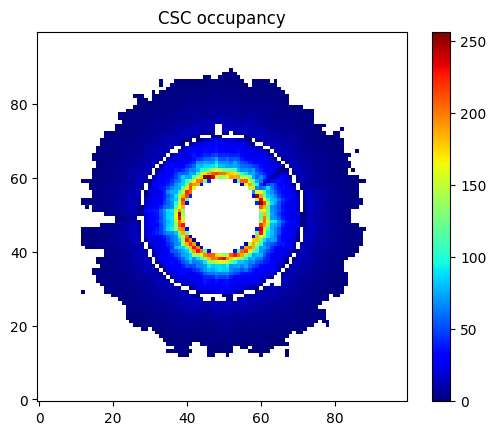

 >> Normalized loss map:


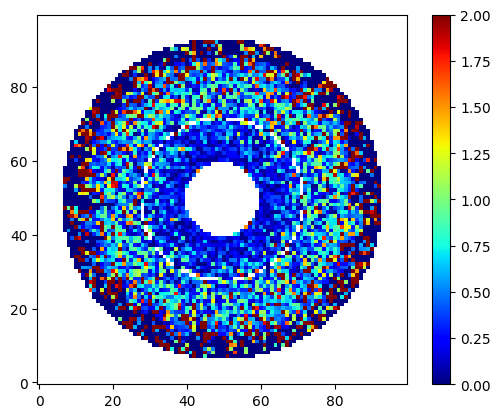

 >> Example 3
 >> Original image:


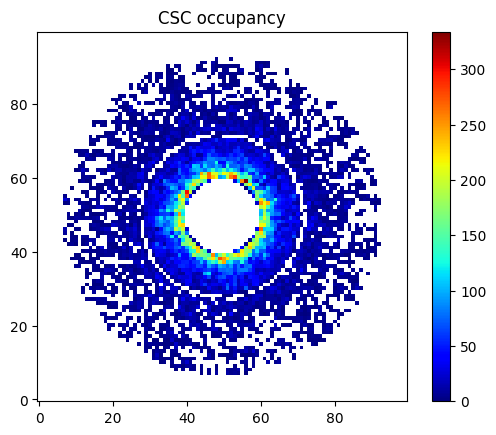

 >> AE-reco image:


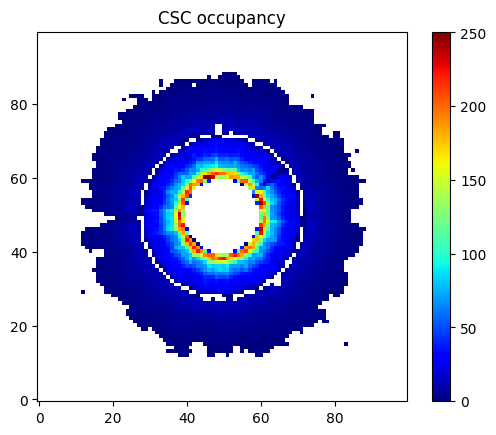

 >> Normalized loss map:


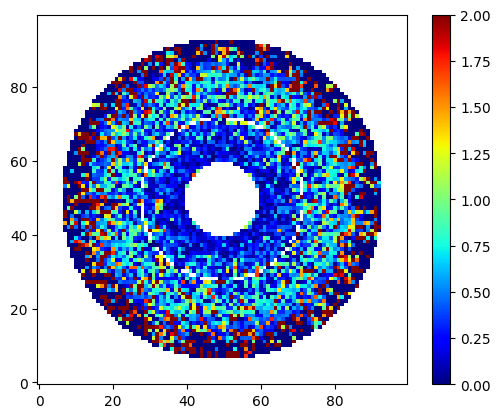

***** batch 18 *****
 >> Example 0
 >> Original image:


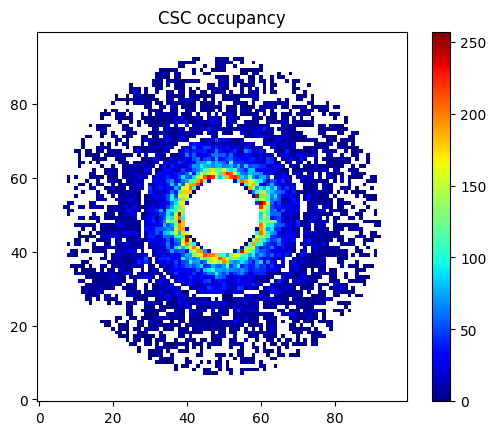

 >> AE-reco image:


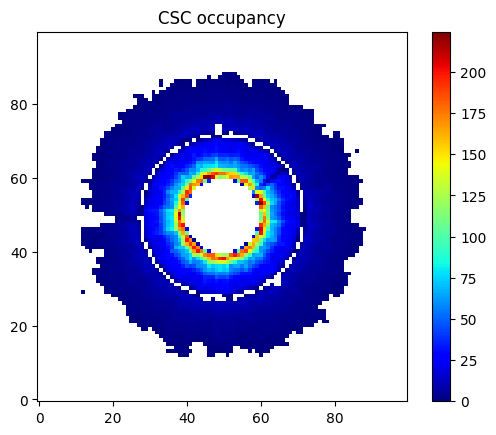

 >> Normalized loss map:


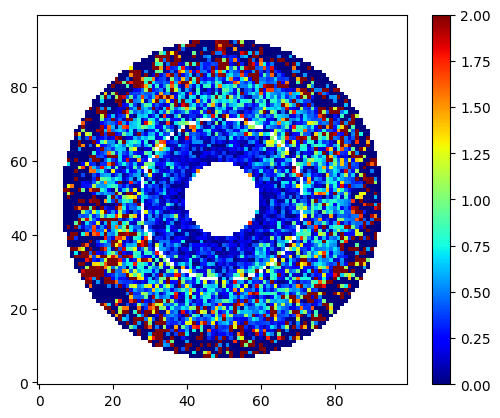

 >> Example 1
 >> Original image:


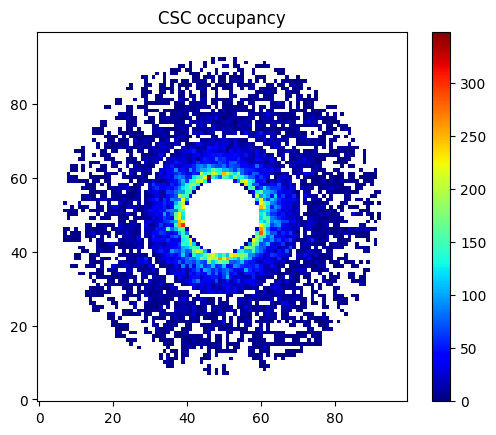

 >> AE-reco image:


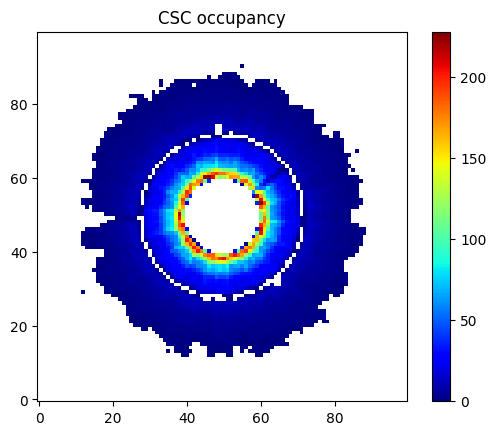

 >> Normalized loss map:


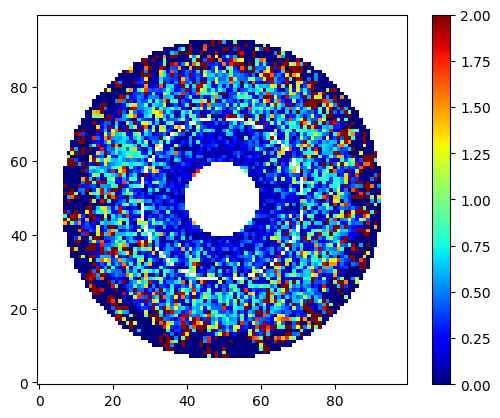

 >> Example 2
 >> Original image:


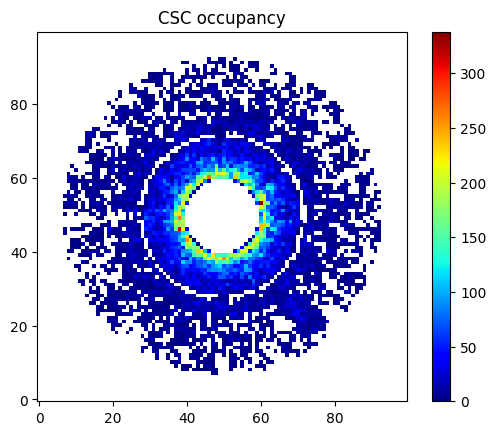

 >> AE-reco image:


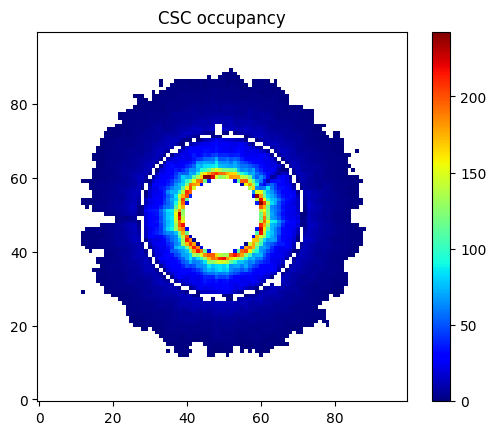

 >> Normalized loss map:


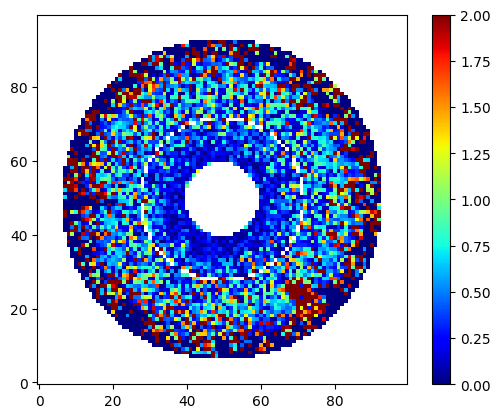

 >> Example 3
 >> Original image:


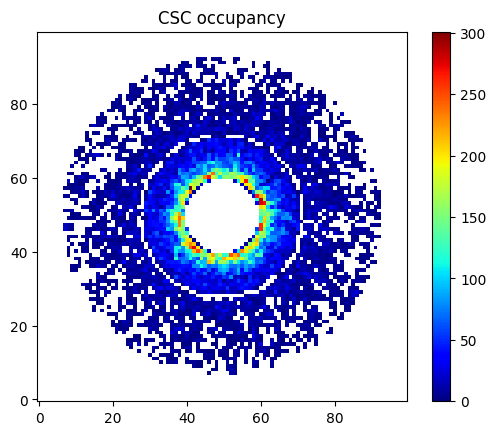

 >> AE-reco image:


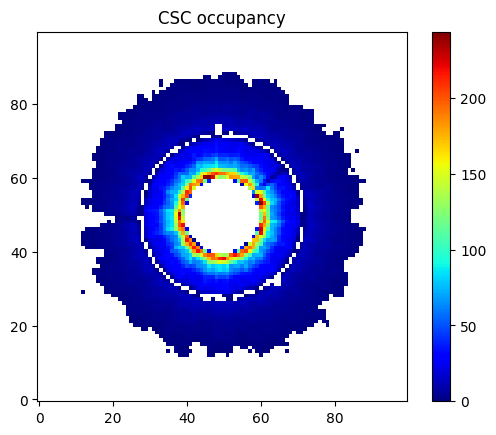

 >> Normalized loss map:


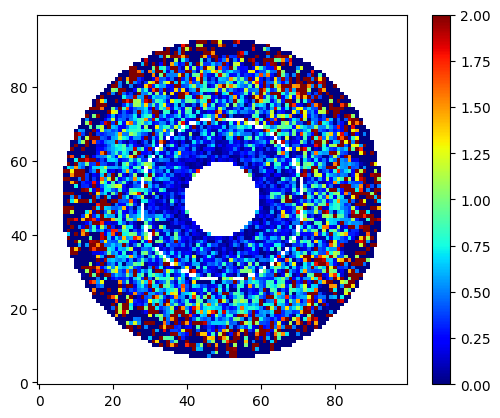

***** batch 19 *****
 >> Example 0
 >> Original image:


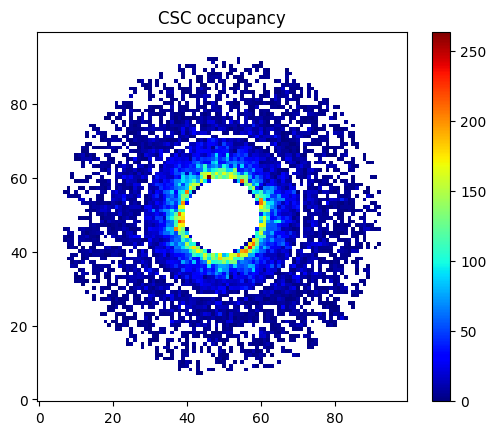

 >> AE-reco image:


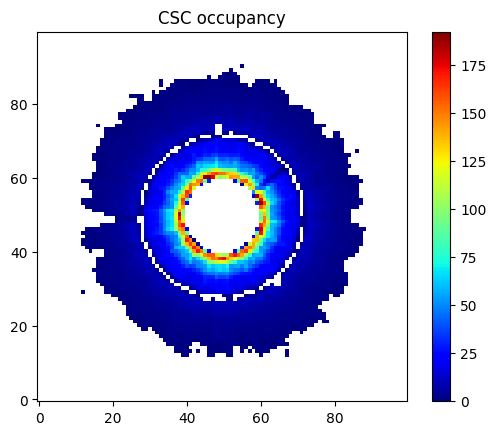

 >> Normalized loss map:


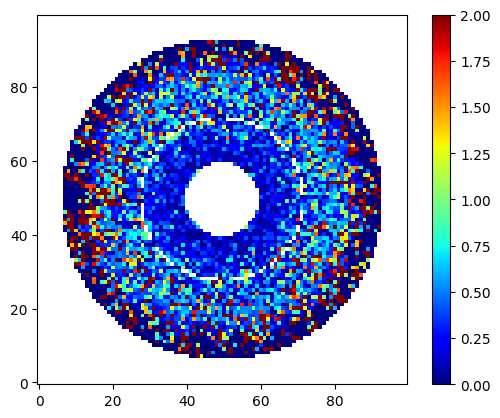

 >> Example 1
 >> Original image:


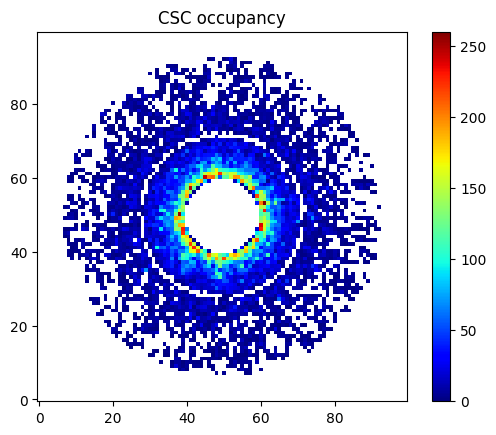

 >> AE-reco image:


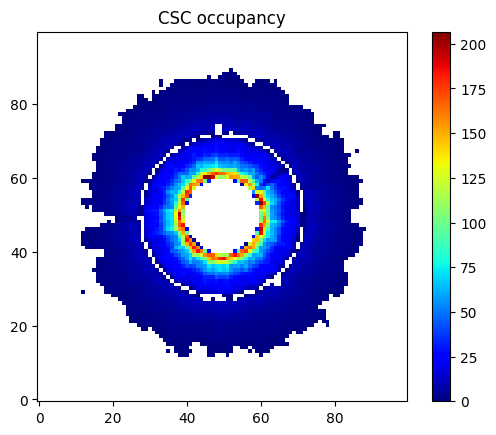

 >> Normalized loss map:


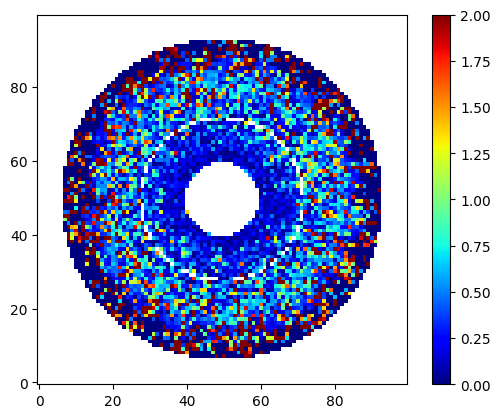

 >> Example 2
 >> Original image:


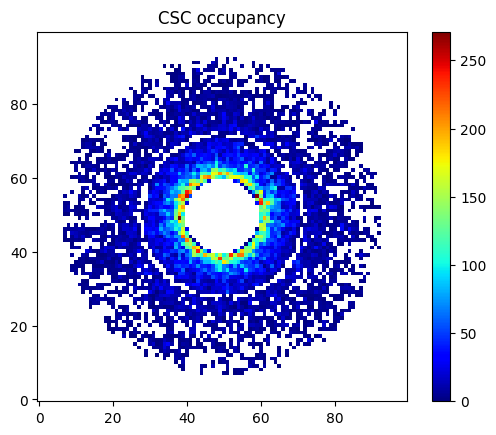

 >> AE-reco image:


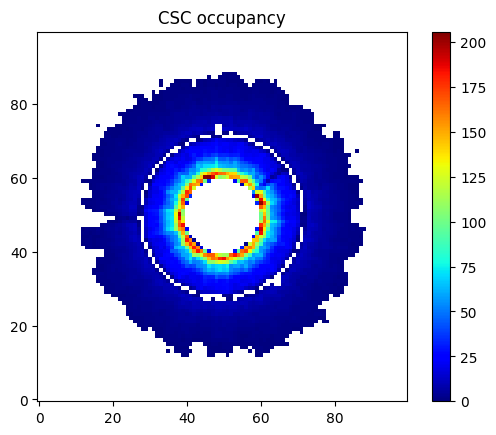

 >> Normalized loss map:


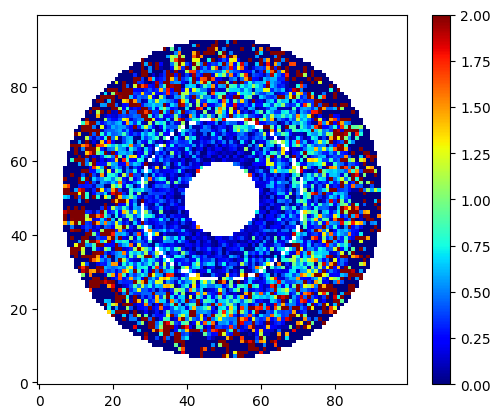

 >> Example 3
 >> Original image:


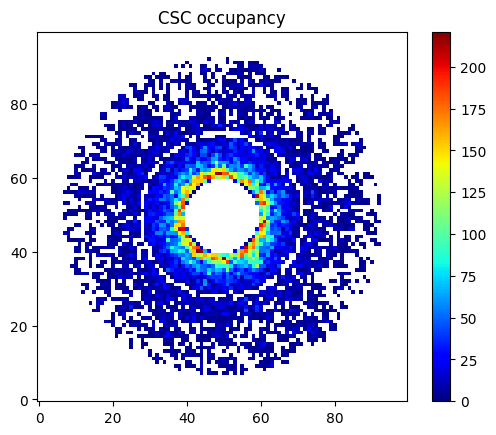

 >> AE-reco image:


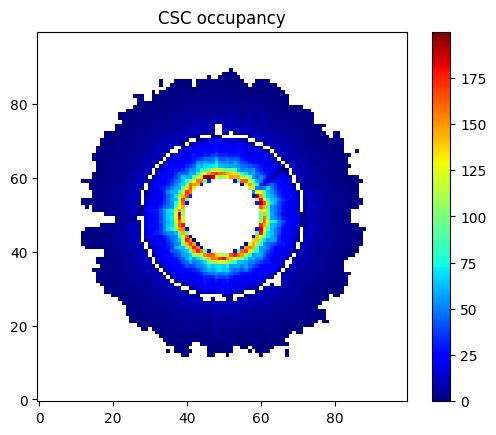

 >> Normalized loss map:


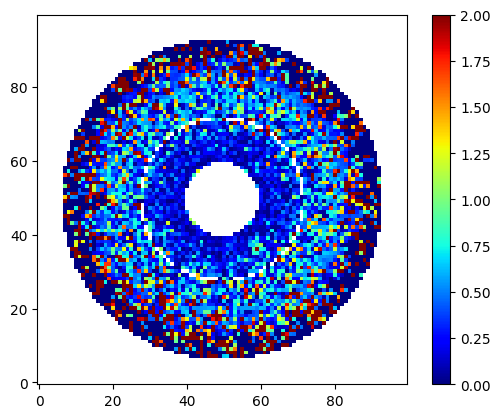

***** batch 20 *****
 >> Example 0
 >> Original image:


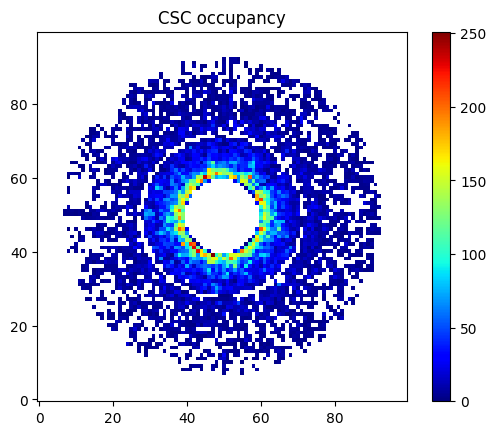

 >> AE-reco image:


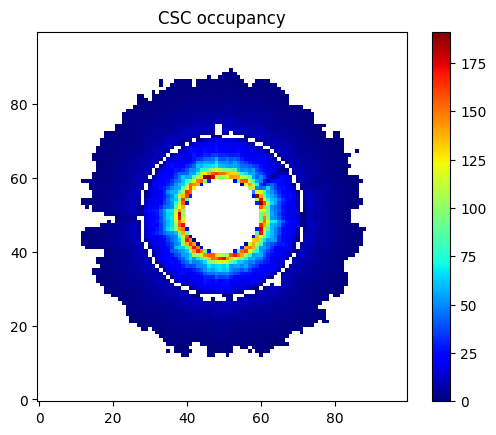

 >> Normalized loss map:


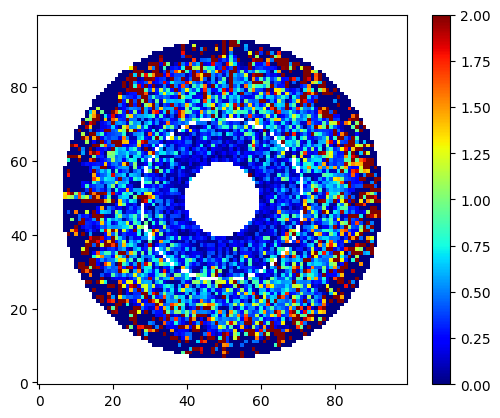

 >> Example 1
 >> Original image:


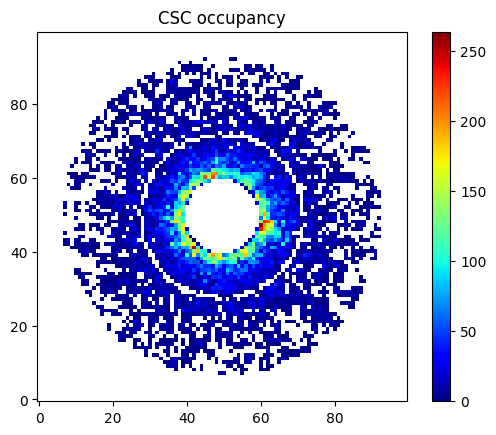

 >> AE-reco image:


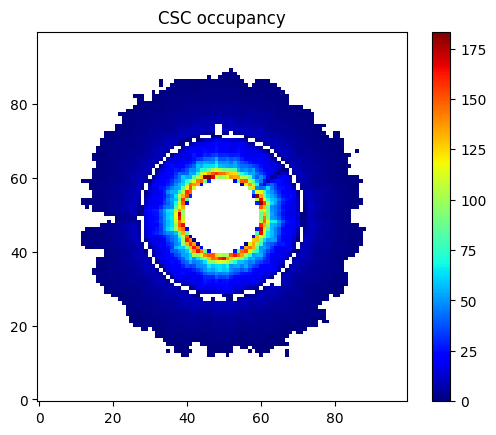

 >> Normalized loss map:


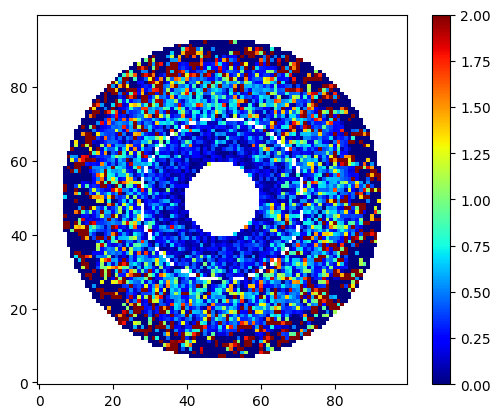

 >> Example 2
 >> Original image:


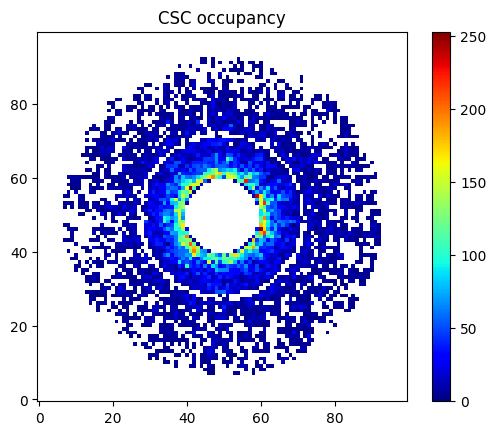

 >> AE-reco image:


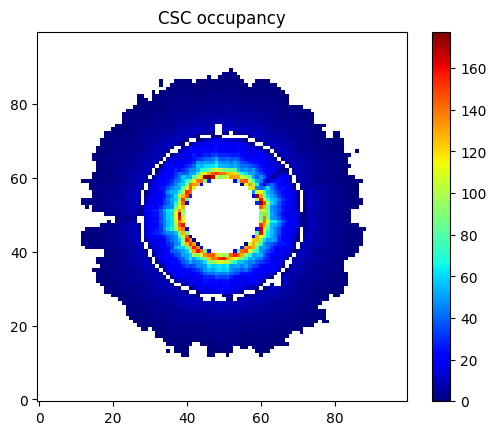

 >> Normalized loss map:


In [ ]:
for i, img in enumerate(validation_loader):
    img = img.to(device)
    #img = img*(img<10).float()
    reco_img = ae(img)
    print(f"***** batch {i} *****")
    #k=0
    #if True:
    for k in range(4):
        print(f" >> Example {k}")
        print(' >> Original image:')
        Show2Dimg(img[k][0].cpu().numpy())
        print(' >> AE-reco image:')
        Show2Dimg(reco_img[k][0].detach().cpu().numpy())
        print(' >> Normalized loss map:')
        img_loss = F.l1_loss(reco_img[k], img[k], reduction='none')[0].detach().cpu().numpy()
        #Show2Dimg(img_loss/mean_matrix)
        out = img_loss/mean_matrix
        plt.imshow(out, cmap=plt.cm.jet, vmin=0, vmax=2)
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.show()